# ĐỒ ÁN GIỮA KỲ: XÂY DỰNG MÔ HÌNH CVAE CHO TỔNG HỢP TÍN HIỆU PPG

## 1. TỔNG QUAN ĐỒ ÁN

### 1.1. Mô tả bài toán

Tín hiệu Photoplethysmography (PPG) là một kỹ thuật đo lường quang học không xâm lấn, được sử dụng để ghi nhận sự thay đổi thể tích máu trong các mạch máu ngoại vi. PPG thường được ứng dụng trong việc theo dõi các chỉ số sinh lý quan trọng như nhịp tim (Heart Rate - HR) và nhịp thở (Breathing Rate - BR).

Trong đồ án này, sinh viên sẽ xây dựng mô hình Conditional Variational Autoencoder (CVAE) để tổng hợp tín hiệu PPG dựa trên các thông số sinh lý cho trước (nhịp tim và tốc độ hô hấp). Dữ liệu đã được tiền xử lý thành các đoạn tín hiệu dài 1250 điểm (khoảng 10 giây).

### 1.2. Mục tiêu

- Hiểu nguyên lý hoạt động của mô hình CVAE
- Xây dựng và huấn luyện mô hình CVAE để tổng hợp tín hiệu PPG
- Nâng cao: Xây dựng mô hình CNN-CVAE cải tiến
- Đánh giá hiệu quả mô hình thông qua các chỉ số định lượng và định tính

### 1.3. Ứng dụng

- Mở rộng tập dữ liệu huấn luyện cho các mô hình học máy trong lĩnh vực y tế
- Mô phỏng tín hiệu sinh lý phục vụ nghiên cứu hoặc kiểm tra thiết bị y tế
- Tạo dữ liệu tổng hợp cho các ứng dụng theo dõi sức khỏe

## 2. YÊU CẦU VỀ TỔ CHỨC CODE

### 2.1. Nguyên tắc tổ chức notebook

- Notebook phải được tổ chức theo các section rõ ràng, có tiêu đề và mô tả cho từng phần
- Các cell phải được chạy theo thứ tự từ trên xuống dưới và không có lỗi
- Mỗi cell nên thực hiện một chức năng cụ thể và có comment đầy đủ
- Kết quả của mỗi bước xử lý cần được hiển thị ngay sau cell tương ứng

### 2.2. Kiểm tra kết quả trước khi lưu

- **Nguyên tắc quan trọng**: Luôn hiển thị và kiểm tra kết quả trước khi lưu thành file hoặc hình ảnh
- Tổ chức thành 2 cell riêng biệt:
  - Cell 1: Thực hiện xử lý và hiển thị kết quả để kiểm tra
  - Cell 2: Lưu kết quả đã kiểm tra thành file hoặc hình ảnh

### 2.3. Hiển thị thông tin chi tiết

- Hiển thị thông tin về cấu trúc dữ liệu sau mỗi bước xử lý (shape, type, min/max values)
- In ra các thông số chính của mô hình sau khi định nghĩa (summary)
- Hiển thị các metrics trong quá trình huấn luyện để theo dõi
- Visualize các kết quả trung gian để kiểm tra tính đúng đắn

### 2.4. Xử lý lỗi

- Thêm các khối try-except để xử lý các lỗi có thể xảy ra
- In ra thông báo lỗi rõ ràng giúp dễ dàng debug
- Kiểm tra các điều kiện đầu vào trước khi thực hiện các phép tính phức tạp

## 3. DỮ LIỆU

### 3.1. Bộ dữ liệu

- Dữ liệu huấn luyện: 3724 đoạn tín hiệu PPG
- Dữ liệu kiểm thử: 931 đoạn tín hiệu PPG
- Mỗi đoạn tín hiệu có độ dài 1250 điểm
- Thông số điều kiện: HR (nhịp tim) và BR (tốc độ hô hấp)

### 3.2. Khám phá dữ liệu

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

In [44]:

data_path = "drive/MyDrive/dataIOT/BIDMC_data/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc_data.mat"
output_base_path = 'drive/MyDrive/KQGK'
figures_path = figures_path = os.path.join(output_base_path, 'figures')
os.makedirs(figures_path, exist_ok=True)

In [45]:
# Tải dữ liệu
print("Đang tải dữ liệu từ file .mat...")
mat_data = sio.loadmat(data_path)
data = mat_data['data'][0]  # Lấy mảng chính chứa 53 bản ghi

# Khám phá cấu trúc dữ liệu
print(f"Số lượng bản ghi: {len(data)}")

# Khám phá cấu trúc chi tiết của bản ghi đầu tiên
first_record = data[0]
print("\nKhám phá cấu trúc chi tiết của bản ghi đầu tiên:")

# Kiểm tra cấu trúc của trường ppg
ppg_field = first_record['ppg'][0, 0]
print(f"Cấu trúc của trường ppg: {type(ppg_field)}")
if hasattr(ppg_field, 'dtype') and hasattr(ppg_field.dtype, 'names'):
    print(f"Các trường con của ppg: {ppg_field.dtype.names}")

# Kiểm tra cấu trúc của trường ref
ref_field = first_record['ref'][0, 0]
print(f"Cấu trúc của trường ref: {type(ref_field)}")
if hasattr(ref_field, 'dtype') and hasattr(ref_field.dtype, 'names'):
    print(f"Các trường con của ref: {ref_field.dtype.names}")

    # Kiểm tra cấu trúc của trường params trong ref
    if 'params' in ref_field.dtype.names:
        params_field = ref_field['params'][0, 0]
        print(f"Cấu trúc của trường params: {type(params_field)}")
        if hasattr(params_field, 'dtype') and hasattr(params_field.dtype, 'names'):
            print(f"Các trường con của params: {params_field.dtype.names}")

Đang tải dữ liệu từ file .mat...
Số lượng bản ghi: 53

Khám phá cấu trúc chi tiết của bản ghi đầu tiên:
Cấu trúc của trường ppg: <class 'numpy.void'>
Các trường con của ppg: ('v', 'fs', 'method')
Cấu trúc của trường ref: <class 'numpy.void'>
Các trường con của ref: ('resp_sig', 'breaths', 'params')
Cấu trúc của trường params: <class 'numpy.void'>
Các trường con của params: ('rr', 'hr', 'pr', 'spo2')



Kiểm tra chi tiết hơn về cấu trúc dữ liệu:
Kiểu dữ liệu của ppg.v: <class 'numpy.ndarray'>
Kích thước của ppg.v: (60001, 1)

Kiểm tra cấu trúc của HR và RR:
Kiểu dữ liệu của hr: <class 'numpy.ndarray'>
Kích thước của hr: (481, 1)
Giá trị đầu tiên của hr bản ghi đầu


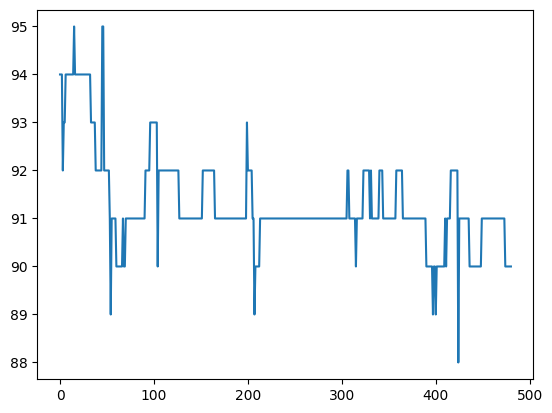

Kiểu dữ liệu của rr: <class 'numpy.ndarray'>
Kích thước của rr: (481, 1)
Giá trị đầu tiên của rr bản ghi đầu


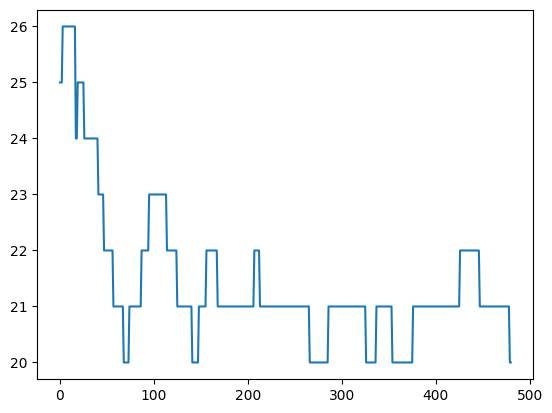

In [46]:
# Kiểm tra chi tiết hơn về cấu trúc dữ liệu
print("\nKiểm tra chi tiết hơn về cấu trúc dữ liệu:")
print(f"Kiểu dữ liệu của ppg.v: {type(first_record['ppg'][0, 0]['v'])}")
print(f"Kích thước của ppg.v: {first_record['ppg'][0, 0]['v'].shape}")

# Kiểm tra cấu trúc của HR và RR
print("\nKiểm tra cấu trúc của HR và RR:")
hr_field = first_record['ref'][0, 0]['params'][0, 0]['hr'][0]
print(f"Kiểu dữ liệu của hr: {type(hr_field)}")
print(f"Kích thước của hr: {hr_field[0][1].shape}")
print(f"Giá trị đầu tiên của hr bản ghi đầu")

plt.figure()
plt.plot(hr_field[0][0],hr_field[0][1])
plt.show()
rr_field = first_record['ref'][0, 0]['params'][0, 0]['rr'][0]
print(f"Kiểu dữ liệu của rr: {type(rr_field)}")
print(f"Kích thước của rr: {hr_field[0][1].shape}")
print(f"Giá trị đầu tiên của rr bản ghi đầu")
plt.figure()
plt.plot(rr_field[0][0],rr_field[0][1])
plt.show()

In [47]:
# Truy cập trực tiếp vào dữ liệu PPG
ppg_data = first_record['ppg'][0, 0]['v']
if isinstance(ppg_data, np.ndarray):
    # Nếu là mảng numpy, lấy dữ liệu trực tiếp
    sample_ppg = ppg_data.flatten()
else:
    # Nếu không phải mảng numpy, chuyển đổi thành mảng
    sample_ppg = np.array(ppg_data, dtype=float).flatten()

# Lấy tần số lấy mẫu
sample_fs_ppg = float(first_record['ppg'][0, 0]['fs'][0, 0])

# Tương tự cho ECG và Resp
ecg_data = first_record['ekg'][0, 0]['v']
if isinstance(ecg_data, np.ndarray):
    sample_ecg = ecg_data.flatten()
else:
    sample_ecg = np.array(ecg_data, dtype=float).flatten()

sample_fs_ecg = float(first_record['ekg'][0, 0]['fs'][0, 0])

resp_data = first_record['ref'][0, 0]['resp_sig'][0, 0]['imp'][0, 0]['v']
if isinstance(resp_data, np.ndarray):
    sample_resp = resp_data.flatten()
else:
    sample_resp = np.array(resp_data, dtype=float).flatten()

sample_fs_resp = float(first_record['ref'][0, 0]['resp_sig'][0, 0]['imp'][0, 0]['fs'][0, 0])

print(f"\nTần số lấy mẫu PPG: {sample_fs_ppg} Hz")
print(f"Tần số lấy mẫu ECG: {sample_fs_ecg} Hz")
print(f"Tần số lấy mẫu Resp: {sample_fs_resp} Hz")

print(f"Độ dài tín hiệu PPG: {len(sample_ppg)} mẫu")
print(f"Độ dài tín hiệu ECG: {len(sample_ecg)} mẫu")
print(f"Độ dài tín hiệu Resp: {len(sample_resp)} mẫu")


Tần số lấy mẫu PPG: 125.0 Hz
Tần số lấy mẫu ECG: 125.0 Hz
Tần số lấy mẫu Resp: 125.0 Hz
Độ dài tín hiệu PPG: 60001 mẫu
Độ dài tín hiệu ECG: 60001 mẫu
Độ dài tín hiệu Resp: 60001 mẫu


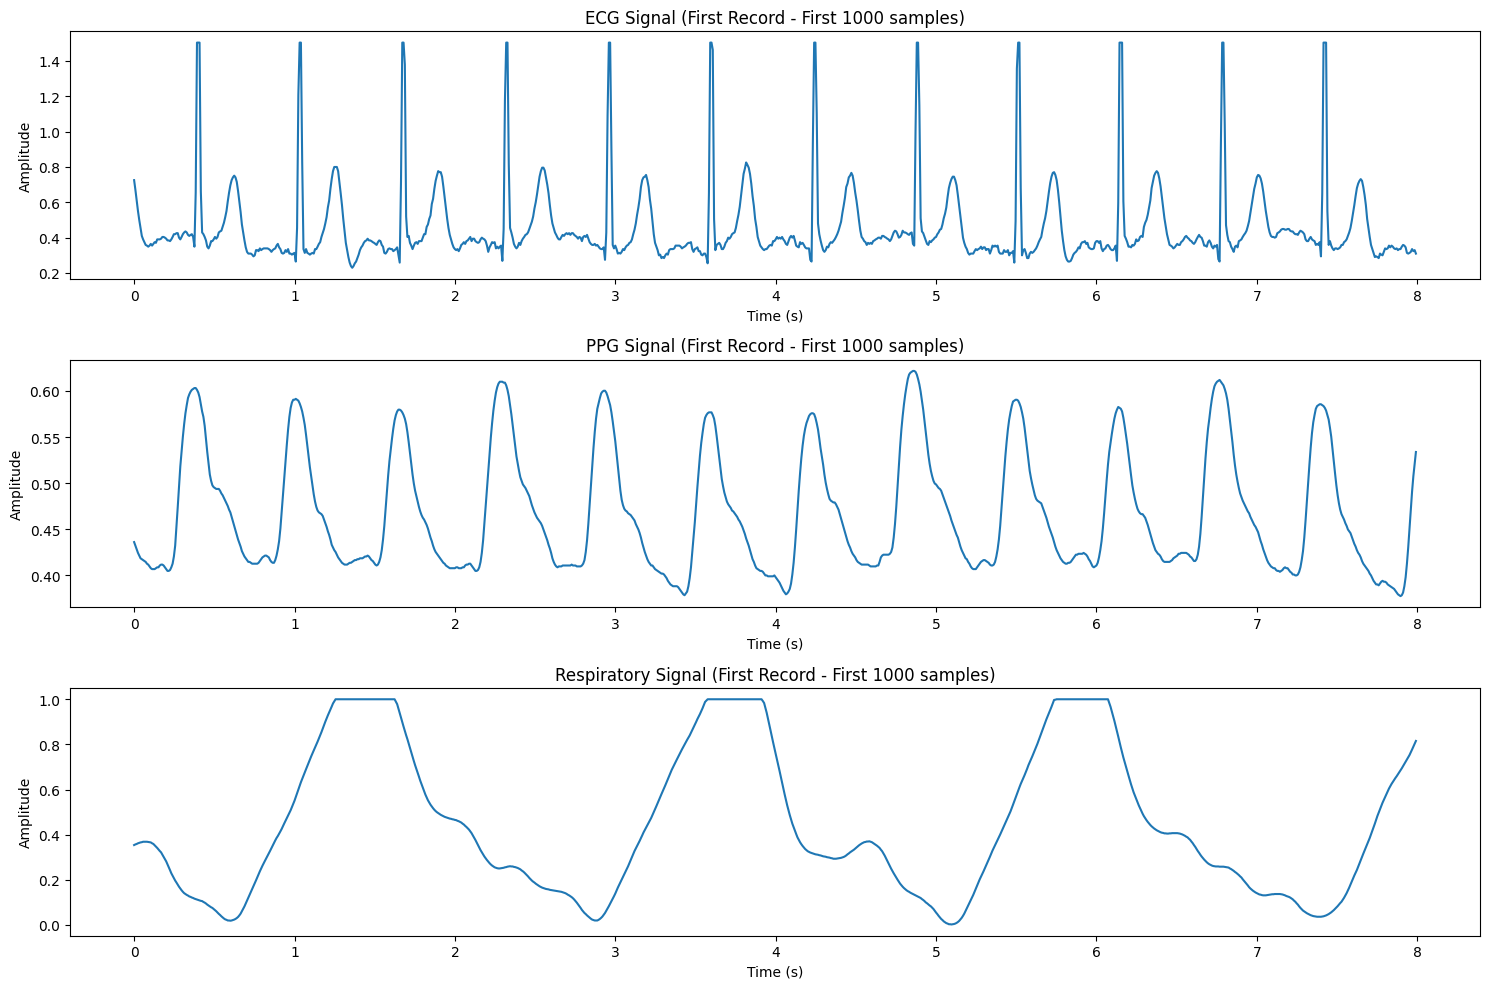

In [48]:
# Tính thời gian cho trục x
time_ppg = np.arange(len(sample_ppg)) / sample_fs_ppg
time_ecg = np.arange(len(sample_ecg)) / sample_fs_ecg
time_resp = np.arange(len(sample_resp)) / sample_fs_resp

# Vẽ tín hiệu mẫu
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(time_ecg[:1000], sample_ecg[:1000])
plt.title('ECG Signal (First Record - First 1000 samples)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(time_ppg[:1000], sample_ppg[:1000])
plt.title('PPG Signal (First Record - First 1000 samples)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(time_resp[:1000], sample_resp[:1000])
plt.title('Respiratory Signal (First Record - First 1000 samples)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'sample_signals.png'))
plt.show()
plt.close()

In [49]:
#Thu thập HR và RR từ tất cả các bản ghi
all_hr_values = []
all_rr_values = []
all_ppg_values = []
for i in range(len(data)):
    try:
        record = data[i]
        ppg_data = record['ppg'][0, 0]['v']
        params = record['ref'][0, 0]['params'][0, 0]

        # Lấy HR, RR, PR và SpO2 từ mỗi bản ghi
        hr_data = params['hr'][0]['v'][0].flatten()
        rr_data = params['rr'][0]['v'][0].flatten()
        try:
            hr_values = np.array(hr_data, dtype=float)
            all_hr_values.append(hr_values)
        except:
            print(f"Không thể chuyển đổi HR của bản ghi {i} sang float")
        try:
            rr_values = np.array(rr_data, dtype=float)
            all_rr_values.append(rr_values)
        except:
            print(f"Không thể chuyển đổi RR của bản ghi {i} sang float")
        try:
            ppg_values = np.array(ppg_data, dtype=float)
            all_ppg_values.append(ppg_values)
        except:
            print(f"Không thể chuyển đổi PPG của bản ghi {i} sang float")
    except Exception as e:
        print(f"Lỗi khi xử lý bản ghi {i}: {e}")
print("Trích xuất PPG, HR và RR thành công")

Trích xuất PPG, HR và RR thành công



Thống kê HR (Heart Rate):
Min: 44.00, Max: 139.00, Mean: 89.18, Std: 13.33

Thống kê RR (Respiratory Rate):
Min: 0.00, Max: 34.00, Mean: 17.50, Std: 3.44


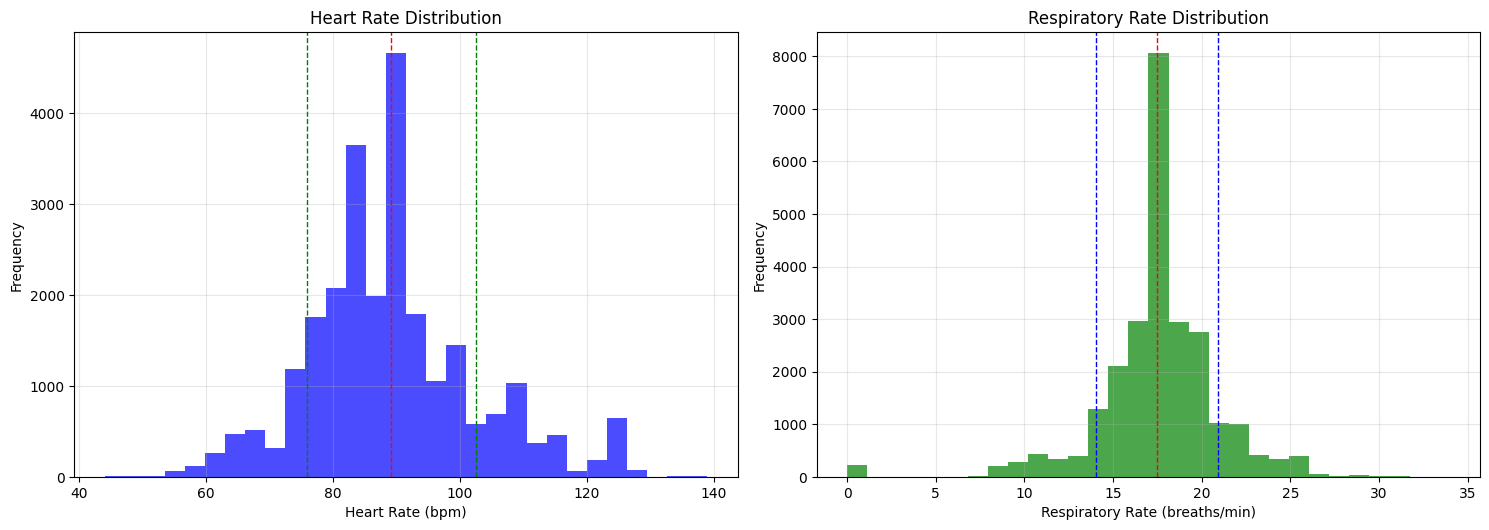

In [50]:
import pickle
if all_hr_values and all_rr_values and all_ppg_values:
  try:
    # Ghép các mảng lại với nhau
    all_hr = np.concatenate([x for x in all_hr_values if x.size > 0])
    all_rr = np.concatenate([x for x in all_rr_values if x.size > 0])
    all_hr = all_hr[~np.isnan(all_hr)]
    all_rr = all_rr[~np.isnan(all_rr)]
    print("\nThống kê HR (Heart Rate):")
    print(f"Min: {np.min(all_hr):.2f}, Max: {np.max(all_hr):.2f}, Mean: {np.mean(all_hr):.2f}, Std: {np.std(all_hr):.2f}")

    print("\nThống kê RR (Respiratory Rate):")
    print(f"Min: {np.min(all_rr):.2f}, Max: {np.max(all_rr):.2f}, Mean: {np.mean(all_rr):.2f}, Std: {np.std(all_rr):.2f}")

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.hist(all_hr, bins=30, alpha=0.7, color='blue')
    plt.axvline(np.mean(all_hr), color='red', linestyle='dashed', linewidth=1)
    plt.axvline(np.mean(all_hr) + np.std(all_hr), color='green', linestyle='dashed', linewidth=1)
    plt.axvline(np.mean(all_hr) - np.std(all_hr), color='green', linestyle='dashed', linewidth=1)
    plt.title('Heart Rate Distribution')
    plt.xlabel('Heart Rate (bpm)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.hist(all_rr, bins=30, alpha=0.7, color='green')
    plt.axvline(np.mean(all_rr), color='red', linestyle='dashed', linewidth=1)
    plt.axvline(np.mean(all_rr) + np.std(all_rr), color='blue', linestyle='dashed', linewidth=1)
    plt.axvline(np.mean(all_rr) - np.std(all_rr), color='blue', linestyle='dashed', linewidth=1)
    plt.title('Respiratory Rate Distribution')
    plt.xlabel('Respiratory Rate (breaths/min)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
  except Exception as e:
        print(f"Lỗi khi xử lý thống kê: {e}")


In [51]:

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist(all_hr, bins=30, alpha=0.7, color='blue')
plt.axvline(np.mean(all_hr), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(all_hr) + np.std(all_hr), color='green', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(all_hr) - np.std(all_hr), color='green', linestyle='dashed', linewidth=1)
plt.title('Heart Rate Distribution')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.hist(all_rr, bins=30, alpha=0.7, color='green')
plt.axvline(np.mean(all_rr), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(all_rr) + np.std(all_rr), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(all_rr) - np.std(all_rr), color='blue', linestyle='dashed', linewidth=1)
plt.title('Respiratory Rate Distribution')
plt.xlabel('Respiratory Rate (breaths/min)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'hr_rr_distribution.png'))
plt.close()

In [52]:
with open(os.path.join(figures_path, 'data_exploration_summary.txt'), 'w') as f:
      f.write("BÁO CÁO KHÁM PHÁ DỮ LIỆU BIDMC PPG AND RESPIRATION DATASET\n")
      f.write("==========================================================\n\n")

      f.write(f"Số lượng bản ghi: {len(data)}\n\n")

      f.write("Cấu trúc dữ liệu:\n")
      f.write("- Mỗi bản ghi chứa các trường: ppg, ekg, ref, fix\n")
      f.write("- Tín hiệu PPG và ECG được lưu trữ với giá trị (v) và tần số lấy mẫu (fs)\n")
      f.write("- Tín hiệu hô hấp được lưu trữ trong trường ref.resp_sig.imp\n")
      f.write("- Các thông số sinh lý (HR, RR, PR, SpO2) được lưu trữ trong trường ref.params\n\n")

      f.write(f"Tần số lấy mẫu PPG: {sample_fs_ppg} Hz\n")
      f.write(f"Tần số lấy mẫu ECG: {sample_fs_ecg} Hz\n")
      f.write(f"Tần số lấy mẫu Resp: {sample_fs_resp} Hz\n\n")

      f.write("Thách thức trong việc truy cập dữ liệu:\n")
      f.write("- Cấu trúc dữ liệu phức tạp với nhiều lớp lồng nhau\n")
      f.write("- Khó khăn trong việc chuyển đổi dữ liệu HR và RR sang định dạng float\n")
      f.write("- Cần phương pháp tiếp cận cẩn thận để trích xuất và xử lý dữ liệu\n\n")

### 3.3. Tiền xử lý dữ liệu

#### 3.3.1. Chuẩn hóa tín hiệu PPG

Tín hiệu PPG cần được chuẩn hóa về khoảng [-1, 1] để phù hợp với hàm kích hoạt tanh ở đầu ra của mô hình CVAE. Sử dụng phương pháp Min-Max Normalization:

In [53]:
def normalize_to_range(data, target_min=-1, target_max=1):
    """
    Chuẩn hóa dữ liệu về khoảng [target_min, target_max].

    Parameters:
    -----------
    data : ndarray
        Dữ liệu cần chuẩn hóa
    target_min : float
        Giá trị nhỏ nhất sau khi chuẩn hóa
    target_max : float
        Giá trị lớn nhất sau khi chuẩn hóa

    Returns:
    --------
    ndarray
        Dữ liệu đã chuẩn hóa
    """
    data_min = np.min(data)
    data_max = np.max(data)

    normalized_data = target_min + (data - data_min) * (target_max - target_min) / (data_max - data_min)
    return normalized_data

#### 3.3.2. Chuẩn hóa các thông số điều kiện (HR và BR)

Đối với các thông số HR và BR, sinh viên phải sử dụng phương pháp Z-score normalization cho toàn bộ dữ liệu:

In [54]:
def z_score_normalize(data,mean,std):
    """
    Chuẩn hóa dữ liệu bằng Z-score (μ=0, σ=1)

    Parameters:
    -----------
    data : ndarray
        Dữ liệu cần chuẩn hóa

    Returns:
    --------
    ndarray
        Dữ liệu đã chuẩn hóa
    """
    return (data-mean)/std

#### 3.3.3. Hàm chia segment

Chia tín hiệu thành các đoạn

In [55]:
def slipt_segment(ppg_arr, hr_values, rr_values, fs, segment_length,overlap,HR_MAX,HR_MIN,RR_MAX,RR_MIN,hr_array,rr_array):
    ppg_segments = []
    hr_segments = []
    rr_segments = []
    step = int(segment_length * (1 - overlap))
    step = max(1, step)
    num_segments = (len(ppg_arr) - segment_length) // step + 1
    hr_fs = len(hr_values) / (len(ppg_arr) / fs)
    samples_per_segment = int(segment_length / fs * hr_fs)

    for j in range(num_segments):
        start = j * step
        end = start + segment_length
        if end <= len(ppg_arr):
            ppg_seg = ppg_arr[start:end]
            hr_start_idx = int(start / fs * hr_fs)
            hr_end_idx = min(int(end / fs * hr_fs), len(hr_values))
            rr_start_idx = int(start / fs * hr_fs)
            rr_end_idx = min(int(end / fs * hr_fs), len(rr_values))

            hr_seg = np.mean(hr_values[hr_start_idx:hr_end_idx]) if hr_end_idx > hr_start_idx else hr_values[hr_start_idx]
            rr_seg = np.mean(rr_values[rr_start_idx:rr_end_idx]) if rr_end_idx > rr_start_idx else rr_values[rr_start_idx]

            if np.isnan(hr_seg) or np.isnan(rr_seg):
              continue
            hr_actual = hr_array[hr_start_idx:hr_end_idx].mean()if (hr_end_idx>hr_start_idx) else hr_array[hr_start_idx]
            rr_actual = rr_array[rr_start_idx:rr_end_idx].mean() if (rr_end_idx>rr_start_idx) else rr_array[rr_start_idx]

            if HR_MIN<=hr_actual<=HR_MAX and RR_MIN<=rr_actual<=RR_MAX:
              ppg_segments.append(normalize_to_range(ppg_seg, -1, 1))
              hr_segments.append(hr_seg)
              rr_segments.append(rr_seg)

    return ppg_segments, hr_segments, rr_segments

#### 3.3.4. Hàm lọc tín hiệu PPG

 Lọc nhiễu tín hiệu PPG bằng cách giữ lại dải tần số mong muốn và loại bỏ tần số thấp và cao không cần thiết.

In [56]:
# Hàm lọc nhiễu cho tín hiệu PPG
from scipy.signal import butter, filtfilt
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

#### 3.3.5. Bắt đầu tiền xử lý Bộ BIDMC (Bộ dùng để train)

In [57]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [58]:
processed_data_path = os.path.join(output_base_path, 'processed')

# Tạo thư mục nếu chưa tồn tại
os.makedirs(processed_data_path, exist_ok=True)

print("Thiết lập đường dẫn và thư mục:")
print(f"   - Dữ liệu xử lý: {processed_data_path}")
print("\nHoàn tất thiết lập.")

Thiết lập đường dẫn và thư mục:
   - Dữ liệu xử lý: drive/MyDrive/KQGK/processed

Hoàn tất thiết lập.


In [59]:
print("Đang tải dữ liệu từ file .mat...")
if not os.path.exists(data_path):
    print(f"LỖI: Không tìm thấy file dữ liệu tại: {data_path}")
    print("Vui lòng kiểm tra lại đường dẫn hoặc tải file lên Google Drive.")
else:
    try:
        mat_data = sio.loadmat(data_path)
        # Cấu trúc dữ liệu có thể khác nhau, kiểm tra key 'data'
        if 'data' in mat_data:
            data = mat_data['data'][0]
            print(f"Tải thành công. Số lượng bản ghi: {len(data)}")
        else:
            print("LỖI: Không tìm thấy key 'data' trong file .mat.")
            print(f"Các keys có trong file: {mat_data.keys()}")

    except Exception as e:
      print(f"Lỗi khi tải hoặc khám phá dữ liệu: {e}")

Đang tải dữ liệu từ file .mat...
Tải thành công. Số lượng bản ghi: 53


In [60]:
fs = 125  # Tần số lấy mẫu của tín hiệu PPG
segment_length_sec = 10 # Độ dài mỗi đoạn tín hiệu (giây)
segment_length = segment_length_sec * fs # Độ dài đoạn (samples)
overlap = 0.5 # Độ chồng chéo giữa các đoạn
lowcut = 0.5 # Tần số cắt dưới của bộ lọc bandpass (Hz)
highcut = 8.0 # Tần số cắt trên của bộ lọc bandpass (Hz)

ppg_segments = []
hr_segments = []
rr_segments = []

In [61]:
all_hr_values = []
all_rr_values = []
all_ppg_values = []

#Thu thập tất cả giá trị HR và RR từ các bản ghi
for i, record in enumerate(data):
  try:
    params = record['ref'][0, 0]['params'][0, 0]
    hr_values = params['hr'][0]['v'][0].flatten()
    rr_values = params['rr'][0]['v'][0].flatten()
    ppg = record['ppg'][0, 0]['v'].flatten()

    if (len(hr_values)>0 and len(rr_values)>0):
      all_hr_values.append(hr_values)
      all_rr_values.append(rr_values)
      all_ppg_values.extend(ppg)
  except Exception as e:
    print(f"Lỗi khi xử lý bản ghi {i}: {e}")

hr_mean = np.nanmean(all_hr_values)
rr_mean = np.nanmean(all_rr_values)
hr_std = np.nanstd(all_hr_values)
rr_std = np.nanstd(all_rr_values)

HR_MIN = hr_mean - hr_std
HR_MAX = hr_mean + hr_std
RR_MIN = rr_mean - rr_std
RR_MAX = rr_mean + rr_std
print("Thống kê HR và RR")
print(f"HR_MIN: {HR_MIN}, HR_MAX: {HR_MAX}, HR_MEAN: {hr_mean}, HR_STD: {hr_std}")
print(f"RR_MIN: {RR_MIN}, RR_MAX: {RR_MAX}, RR_MEAN: {rr_mean}, RR_STD: {rr_std}")

Thống kê HR và RR
HR_MIN: 75.85409734735894, HR_MAX: 102.50707806164102, HR_MEAN: 89.18058770449998, HR_STD: 13.326490357141038
RR_MIN: 14.052560026740329, RR_MAX: 20.941678331586427, RR_MEAN: 17.497119179163377, RR_STD: 3.4445591524230488


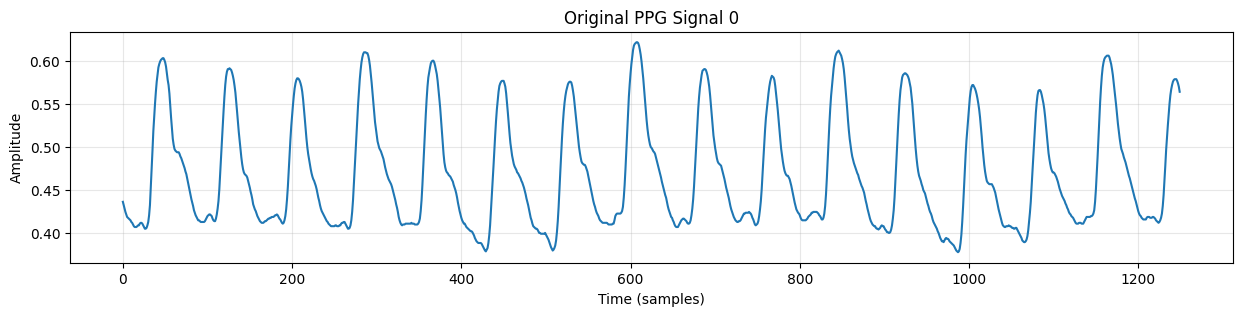

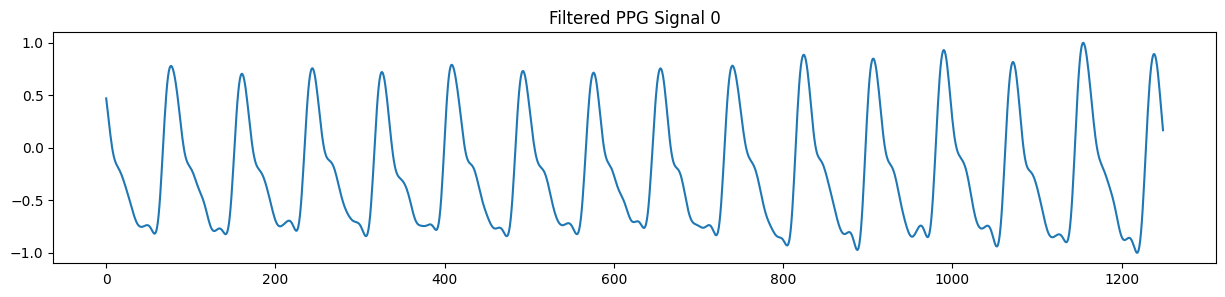

Bản ghi 12 không đủ dữ liệu để xử lý
Bản ghi 14 không đủ dữ liệu để xử lý
Bản ghi 15 không đủ dữ liệu để xử lý
Bản ghi 20 không đủ dữ liệu để xử lý
Bản ghi 23 không đủ dữ liệu để xử lý
Bản ghi 24 không đủ dữ liệu để xử lý
Bản ghi 31 không đủ dữ liệu để xử lý
Bản ghi 39 không đủ dữ liệu để xử lý
Bản ghi 44 không đủ dữ liệu để xử lý
Bản ghi 45 không đủ dữ liệu để xử lý
Bản ghi 46 không đủ dữ liệu để xử lý
Bản ghi 51 không đủ dữ liệu để xử lý
Tổng kết tiền xử lý
Số lượng bản ghi đã xử lý: 41
Tổng số lượng đoạn tín hiệu: 2844


In [62]:
#Xử lý dữ liệu với phạm vi HR và RR đã xác định
ppg_segments = []
hr_segments = []
rr_segments = []
valid_records = 0;
for i, record in enumerate(data):
  try:
    ppg = record['ppg'][0, 0]['v'].flatten()
    params = record['ref'][0, 0]['params'][0, 0]
    hr_values = params['hr'][0]['v'][0].flatten()
    rr_values = params['rr'][0]['v'][0].flatten()

    if (len(hr_values)<2 or len(rr_values)<2):
      print(f"Bản ghi {i} không đủ dữ liệu để xử lý")
      continue
    ppg_filtered = butter_bandpass_filter(ppg,lowcut,highcut,fs)
    hr_normalized = z_score_normalize(hr_values,hr_mean ,hr_std)
    rr_normalized = z_score_normalize(rr_values,rr_mean,rr_std)
    # chia du lieu (chi lay hr trong mean +- std va chuan hoa ppg [-1,1] cho segment)
    ppg_segment,hr_segment,rr_segment = slipt_segment(ppg_filtered,hr_normalized,rr_normalized,fs,segment_length,0.5,HR_MAX,HR_MIN,RR_MAX,RR_MIN,hr_values,rr_values)
    if (len(ppg_segment)==0 or len(hr_segment)==0 or len(rr_segment)==0):
      print(f"Bản ghi {i} không đủ dữ liệu để xử lý")
      continue
    valid_records += 1
    ppg_segments.extend(ppg_segment)
    hr_segments.extend(hr_segment)
    rr_segments.extend(rr_segment)
    if i == 0:
      plt.figure(figsize=(15, 3))
      plt.plot(ppg[:1250])
      plt.title('Original PPG Signal 0')
      plt.xlabel('Time (samples)')
      plt.ylabel('Amplitude')
      plt.grid(True, alpha=0.3)
      plt.figure(figsize=(15, 3))
      plt.plot(ppg_segment[0])
      plt.title('Filtered PPG Signal 0')
      plt.show()
  except Exception as e:
    print(f"Lỗi khi xử lý bản ghi {i}: {e}")
print("Tổng kết tiền xử lý")
print(f"Số lượng bản ghi đã xử lý: {valid_records}")
print(f"Tổng số lượng đoạn tín hiệu: {len(ppg_segments)}")

In [63]:
PPG_data = np.array(ppg_segments).astype(np.float32)
PPG_data.shape

(2844, 1250)

In [64]:
HR_data = np.array(hr_segments).astype(np.float32)
HR_data.shape

(2844,)

In [65]:
RR_data = np.array(rr_segments).astype(np.float32)
RR_data.shape

(2844,)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, hr_train, hr_test, rr_train, rr_test = train_test_split(
    PPG_data, HR_data, RR_data, test_size=0.2, random_state=42, shuffle=True
)

print(f" - Kích thước tập huấn luyện (X_train): {X_train.shape}")
print(f" - Kích thước tập kiểm thử (X_test): {X_test.shape}")
print(f" - Kích thước HR huấn luyện (hr_train): {hr_train.shape}")
print(f" - Kích thước RR huấn luyện (rr_train): {rr_train.shape}")
print(f" - Kích thước HR kiểm thử (hr_test): {hr_test.shape}")
print(f" - Kích thước RR kiểm thử (rr_test): {rr_test.shape}")

 - Kích thước tập huấn luyện (X_train): (2275, 1250)
 - Kích thước tập kiểm thử (X_test): (569, 1250)
 - Kích thước HR huấn luyện (hr_train): (2275,)
 - Kích thước RR huấn luyện (rr_train): (2275,)
 - Kích thước HR kiểm thử (hr_test): (569,)
 - Kích thước RR kiểm thử (rr_test): (569,)


In [67]:
# Tạo mảng điều kiện cuối cùng từ giá trị gốc
# Ghép cột HR và RR lại thành mảng điều kiện
condition_train = np.column_stack((hr_train.flatten(), rr_train.flatten())).astype(np.float32)
condition_test = np.column_stack((hr_test.flatten(), rr_test.flatten())).astype(np.float32)

print("\nĐã kết hợp điều kiện HR/RR ")
print(f" - Shape condition_train: {condition_train.shape}")
print(f" - Shape condition_test: {condition_test.shape}")


Đã kết hợp điều kiện HR/RR 
 - Shape condition_train: (2275, 2)
 - Shape condition_test: (569, 2)


In [68]:
print(f"\nĐang lưu dữ liệu đã xử lý vào: {processed_data_path}")
try:
    np.save(os.path.join(processed_data_path, 'X_train.npy'), X_train)
    np.save(os.path.join(processed_data_path, 'X_test.npy'), X_test)
    # Lưu điều kiện kết hợp (giá trị gốc)

    np.save(os.path.join(processed_data_path, 'condition_train_raw.npy'), condition_train)
    np.save(os.path.join(processed_data_path, 'condition_test_raw.npy'), condition_test)

    # Lưu thêm HR/RR riêng lẻ (giá trị gốc) nếu cần cho phân tích sau này
    np.save(os.path.join(processed_data_path, 'hr_train_raw.npy'), hr_train)
    np.save(os.path.join(processed_data_path, 'hr_test_raw.npy'), hr_test)
    np.save(os.path.join(processed_data_path, 'rr_train_raw.npy'), rr_train)
    np.save(os.path.join(processed_data_path, 'rr_test_raw.npy'), rr_test)
    np.save(os.path.join(processed_data_path, 'hr_mean.npy'), hr_mean)
    np.save(os.path.join(processed_data_path, 'hr_std.npy'), hr_std)
    np.save(os.path.join(processed_data_path, 'rr_mean.npy'), rr_mean)
    np.save(os.path.join(processed_data_path, 'rr_std.npy'), rr_std)
    print("Lưu file dữ liệu thành công.")
except Exception as e:
    print(f"Lỗi khi lưu file dữ liệu: {e}")

print("\n--- Hoàn tất Tiền xử lý dữ liệu ---")


Đang lưu dữ liệu đã xử lý vào: drive/MyDrive/KQGK/processed
Lưu file dữ liệu thành công.

--- Hoàn tất Tiền xử lý dữ liệu ---


#### 3.3.6. Bắt đầu tiền xử lý Bộ Capnobase (Bộ dùng để test)

In [69]:
path_capno = "drive/MyDrive/dataIOT/CapnoBase IEEE TBME Respiratory Rate Benchmark/dataverse_files/data/csv"
import pandas as pd
import glob
files_signal_capno = glob.glob(os.path.join(path_capno, "*signal.csv"))
files_Numerics_capno = [item.replace("signal.csv", "reference.csv") for item in files_signal_capno]

In [70]:
# Hàm thay đôi tần số lấy mẫu
from scipy.signal import resample

def resaple(signal, fs_old=300, fs_new=125):
    num_samples = int(len(signal) * fs_new / fs_old)  # Số điểm mới
    resampled = resample(signal, num_samples)
    return resampled

In [71]:
#Hàm trích xuất hr và rr từ PPGPPG
def extract_br_from_ppg(ppg_signal, fs=250):
    """
    Trích xuất nhịp thở từ tín hiệu PPG dựa trên biến thiên tần số thấp.
    Parameters:
    -----------
    ppg_signal : ndarray
        Tín hiệu PPG
    fs : int
        Tần số lấy mẫu (Hz)
    Returns:
    --------
    float
        Nhịp thở (bpm)
    """
    from scipy import signal
    from scipy.fft import fft, fftfreq
    # Lọc thông thấp để lấy biến thiên tần số thấp (respiration)
    b, a = signal.butter(3, [0.1, 0.5], 'bandpass', fs=fs)
    filtered_signal = signal.filtfilt(b, a, ppg_signal)
    # Thực hiện FFT
    fft_result = fft(filtered_signal)
    freq = fftfreq(len(filtered_signal), 1/fs)
    # Chỉ quan tâm đến nửa đầu của FFT và tần số dương
    pos_freq_idx = np.where((freq > 0.1) & (freq < 0.5))
    fft_magnitude = np.abs(fft_result[pos_freq_idx])
    pos_freq = freq[pos_freq_idx]
    if len(fft_magnitude) == 0:
        return 0
    # Tìm tần số với biên độ lớn nhất trong dải 0.1-0.5 Hz (tương ứng với 6-30 breaths/min)
    max_idx = np.argmax(fft_magnitude)
    br_freq = pos_freq[max_idx]
    # Chuyển đổi sang bpm
    br = br_freq * 60
    return br

def extract_hr_from_ppg(ppg_signal, fs=250):
    """
    Trích xuất nhịp tim từ tín hiệu PPG.
    Parameters:
    -----------
    ppg_signal : ndarray
        Tín hiệu PPG
    fs : int
        Tần số lấy mẫu (Hz)
    Returns:
    --------
    float
        Nhịp tim (bpm)
    """
    from scipy.signal import find_peaks
    # Tìm các đỉnh trong tín hiệu PPG
    peaks, _ = find_peaks(ppg_signal, distance=fs*0.5)  # Giả sử HR tối thiểu là 30 bpm
    if len(peaks) < 2:
        return 0
    # Tính toán khoảng cách trung bình giữa các đỉnh (tính theo mẫu)
    peak_intervals = np.diff(peaks)
    avg_interval = np.mean(peak_intervals)
    # Chuyển đổi sang bpm
    hr = 60 * fs / avg_interval
    return hr

In [72]:
# ham chia segment danh cho Capnobase
def slipt_segment_capno(ppg_arr,hr_time, hr_values,rr_time, rr_values, fs, segment_length,overlap,HR_MAX,HR_MIN,RR_MAX,RR_MIN):
    ppg_segments = []
    hr_segments = []
    rr_segments = []
    step = int(segment_length * (1 - overlap))
    step = max(1, step)
    num_segments = (len(ppg_arr) - segment_length) // step + 1

    for j in range(num_segments):
        start = j * step
        time_start = (1/fs)*start

        end = start + segment_length
        time_end = (1/fs)*end

        if end <= len(ppg_arr):
            ppg_seg = ppg_arr[start:end]

            idx_range_hr = np.where((hr_time >= time_start) & (hr_time <= time_end))[0]
            hr_seg = np.mean(hr_values[idx_range_hr]) if (len(idx_range_hr)!=0) else extract_hr_from_ppg(ppg_seg)

            idx_range_rr = np.where((rr_time >= time_start) & (rr_time <= time_end))[0]
            rr_seg = np.mean(rr_values[idx_range_rr])  if (len(idx_range_rr)!=0) else extract_br_from_ppg(ppg_seg)

            if np.isnan(hr_seg) or np.isnan(rr_seg):
              continue
            if HR_MIN<=hr_seg<=HR_MAX and RR_MIN<=rr_seg<=RR_MAX:
              ppg_segments.append(normalize_to_range(ppg_seg, -1, 1))
              hr_segments.append(z_score_normalize(hr_seg,hr_mean,hr_std))
              rr_segments.append(z_score_normalize(rr_seg,rr_mean,rr_std))
    return ppg_segments, hr_segments, rr_segments

In [73]:
# Tiền xử lílí
ppg_segments = []
hr_segments = []
rr_segments = []
valid_records = 0

for i in range(len(files_signal_capno)):

  ppg = pd.read_csv(files_signal_capno[i])['pleth_y']

  time_rr = np.array(pd.read_csv(files_Numerics_capno[i])['rr_co2_x'].values[0].split(), dtype=float)
  rr_values = np.array(pd.read_csv(files_Numerics_capno[i])["rr_co2_y"].values[0].split(), dtype=float)

  hr_values_time = np.array(pd.read_csv(files_Numerics_capno[i])["hr_ecg_x"].values[0].split(), dtype=float)
  hr_values = np.array(pd.read_csv(files_Numerics_capno[i])["hr_ecg_y"].values[0].split(), dtype=float)
  # Doi tan so lay mau
  ppg = resaple(ppg)
  ppg_filtered = butter_bandpass_filter(ppg,lowcut,highcut,125)
  # chia du lieu (chi lay hr trong mean +- std của bộ BIDMCBIDMC va chuan hoa ppg [-1,1] cho segment)
  ppg_segment,hr_segment,rr_segment = slipt_segment_capno(ppg_filtered,hr_values_time,hr_values,time_rr,rr_values,125,segment_length,0.5,HR_MAX,HR_MIN,RR_MAX,RR_MIN)
  if (len(ppg_segment)==0 or len(hr_segment)==0 or len(rr_segment)==0):
      print(f"Bản ghi {i} không đủ dữ liệu để xử lý")
      continue
  valid_records += 1
  ppg_segments.extend(ppg_segment)
  hr_segments.extend(hr_segment)
  rr_segments.extend(rr_segment)
  if i == 0:
    plt.figure(figsize=(15, 3))
    plt.plot(ppg[:1250])
    plt.title('Original PPG Signal 0')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.figure(figsize=(15, 3))
    plt.plot(ppg_segment[0])
    plt.title('Filtered PPG Signal 0')
    plt.show()

print("Tổng kết tiền xử lý")
print(f"Số lượng bản ghi đã xử lý: {valid_records}")
print(f"Tổng số lượng đoạn tín hiệu: {len(ppg_segments)}")

Bản ghi 0 không đủ dữ liệu để xử lý
Bản ghi 2 không đủ dữ liệu để xử lý
Bản ghi 3 không đủ dữ liệu để xử lý
Bản ghi 4 không đủ dữ liệu để xử lý
Bản ghi 6 không đủ dữ liệu để xử lý
Bản ghi 9 không đủ dữ liệu để xử lý
Bản ghi 11 không đủ dữ liệu để xử lý
Bản ghi 12 không đủ dữ liệu để xử lý
Bản ghi 13 không đủ dữ liệu để xử lý
Bản ghi 14 không đủ dữ liệu để xử lý
Bản ghi 15 không đủ dữ liệu để xử lý
Bản ghi 16 không đủ dữ liệu để xử lý
Bản ghi 18 không đủ dữ liệu để xử lý
Bản ghi 20 không đủ dữ liệu để xử lý
Bản ghi 21 không đủ dữ liệu để xử lý
Bản ghi 22 không đủ dữ liệu để xử lý
Bản ghi 23 không đủ dữ liệu để xử lý
Bản ghi 24 không đủ dữ liệu để xử lý
Bản ghi 25 không đủ dữ liệu để xử lý
Bản ghi 26 không đủ dữ liệu để xử lý
Bản ghi 27 không đủ dữ liệu để xử lý
Bản ghi 28 không đủ dữ liệu để xử lý
Bản ghi 29 không đủ dữ liệu để xử lý
Bản ghi 30 không đủ dữ liệu để xử lý
Bản ghi 32 không đủ dữ liệu để xử lý
Bản ghi 34 không đủ dữ liệu để xử lý
Bản ghi 35 không đủ dữ liệu để xử lý
Bản ghi

In [74]:
PPG_data = np.array(ppg_segments).astype(np.float32)
HR_data = np.array(hr_segments).astype(np.float32)
RR_data = np.array(rr_segments).astype(np.float32)
# Tạo mảng điều kiện cuối cùng từ giá trị gốc
# Ghép cột HR và RR lại thành mảng điều kiện
condition = np.column_stack((HR_data.flatten(), RR_data.flatten())).astype(np.float32)
print(f"\nĐang lưu dữ liệu đã xử lý vào: {processed_data_path}")
try:
    np.save(os.path.join(processed_data_path, 'X_capno.npy'), PPG_data)
    # Lưu điều kiện kết hợp (giá trị gốc)

    np.save(os.path.join(processed_data_path, 'condition_capno.npy'), condition)
    print("Lưu file dữ liệu thành công.")
except Exception as e:
    print(f"Lỗi khi lưu file dữ liệu: {e}")

print("\n--- Hoàn tất Tiền xử lý dữ liệu ---")


Đang lưu dữ liệu đã xử lý vào: drive/MyDrive/KQGK/processed
Lưu file dữ liệu thành công.

--- Hoàn tất Tiền xử lý dữ liệu ---


## 4. YÊU CẦU CƠ BẢN: XÂY DỰNG MÔ HÌNH CVAE GỐC

### 4.1. Định nghĩa lớp Sampling

In [75]:
output_base_path = 'drive/MyDrive/KQGK'
model_path = os.path.join(output_base_path, 'models')
# Tạo thư mục nếu chưa tồn tại
os.makedirs(model_path, exist_ok=True)

In [76]:
figures_path = figures_path = os.path.join(output_base_path, 'figures')

In [77]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [78]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Tạo epsilon từ phân phối chuẩn
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    def get_config(self): # Thêm get_config để lưu/tải model dễ hơn
        config = super(Sampling, self).get_config()
        return config

### 4.2. Xây dựng Encoder

In [79]:
import keras
def build_encoder(input_dim=1250, condition_dim=2, latent_dim=20):
    """Xây dựng mạng Encoder theo mô tả."""
    # Đầu vào tín hiệu PPG [batch_size, 1250]
    encoder_inputs = layers.Input(shape=(input_dim,), name='encoder_input_signal')

    x = encoder_inputs  # [batch_size, 1250]

    # Đầu vào điều kiện HR và BR [batch_size, 2]
    condition_inputs = layers.Input(shape=(condition_dim,), name='condition_input')

    # Ghép nối tín hiệu PPG với HR và BR → [batch_size, 1252]
    x = layers.Concatenate()([x, condition_inputs])  # [batch_size, 1252]

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)

    # Lớp Dense cho trung bình μ (z_mean): 20 units, activation linear
    z_mean = layers.Dense(latent_dim, activation='linear', name='z_mean')(x)  # [batch_size, 20]

    # Lớp Dense cho log phương sai (z_log_var): 20 units, activation linear
    z_log_var = layers.Dense(latent_dim, activation='linear', name='z_log_var')(x)  # [batch_size, 20]

    # Lấy mẫu z từ z_mean và z_log_var
    z = Sampling(name='z_sampling')([z_mean, z_log_var])
    encoder = Model([encoder_inputs, condition_inputs], [z_mean, z_log_var, z], name='encoder')
    return encoder

# Tạo mô hình encoder
encoder =build_encoder(1250,2,32)

# Hiển thị cấu trúc encoder để kiểm tra
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_signal      │ (None, 1250)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ condition_input           │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1252)           │              0 │ encoder_input_signal[… │
│ (Concatenate)             │                        │                │ condition_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │        320,768 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         32,896 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          8,256 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │          2,080 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │          2,080 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_sampling (Sampling)     │ (None, 32)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 366,080 (1.40 MB)

 Trainable params: 366,080 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

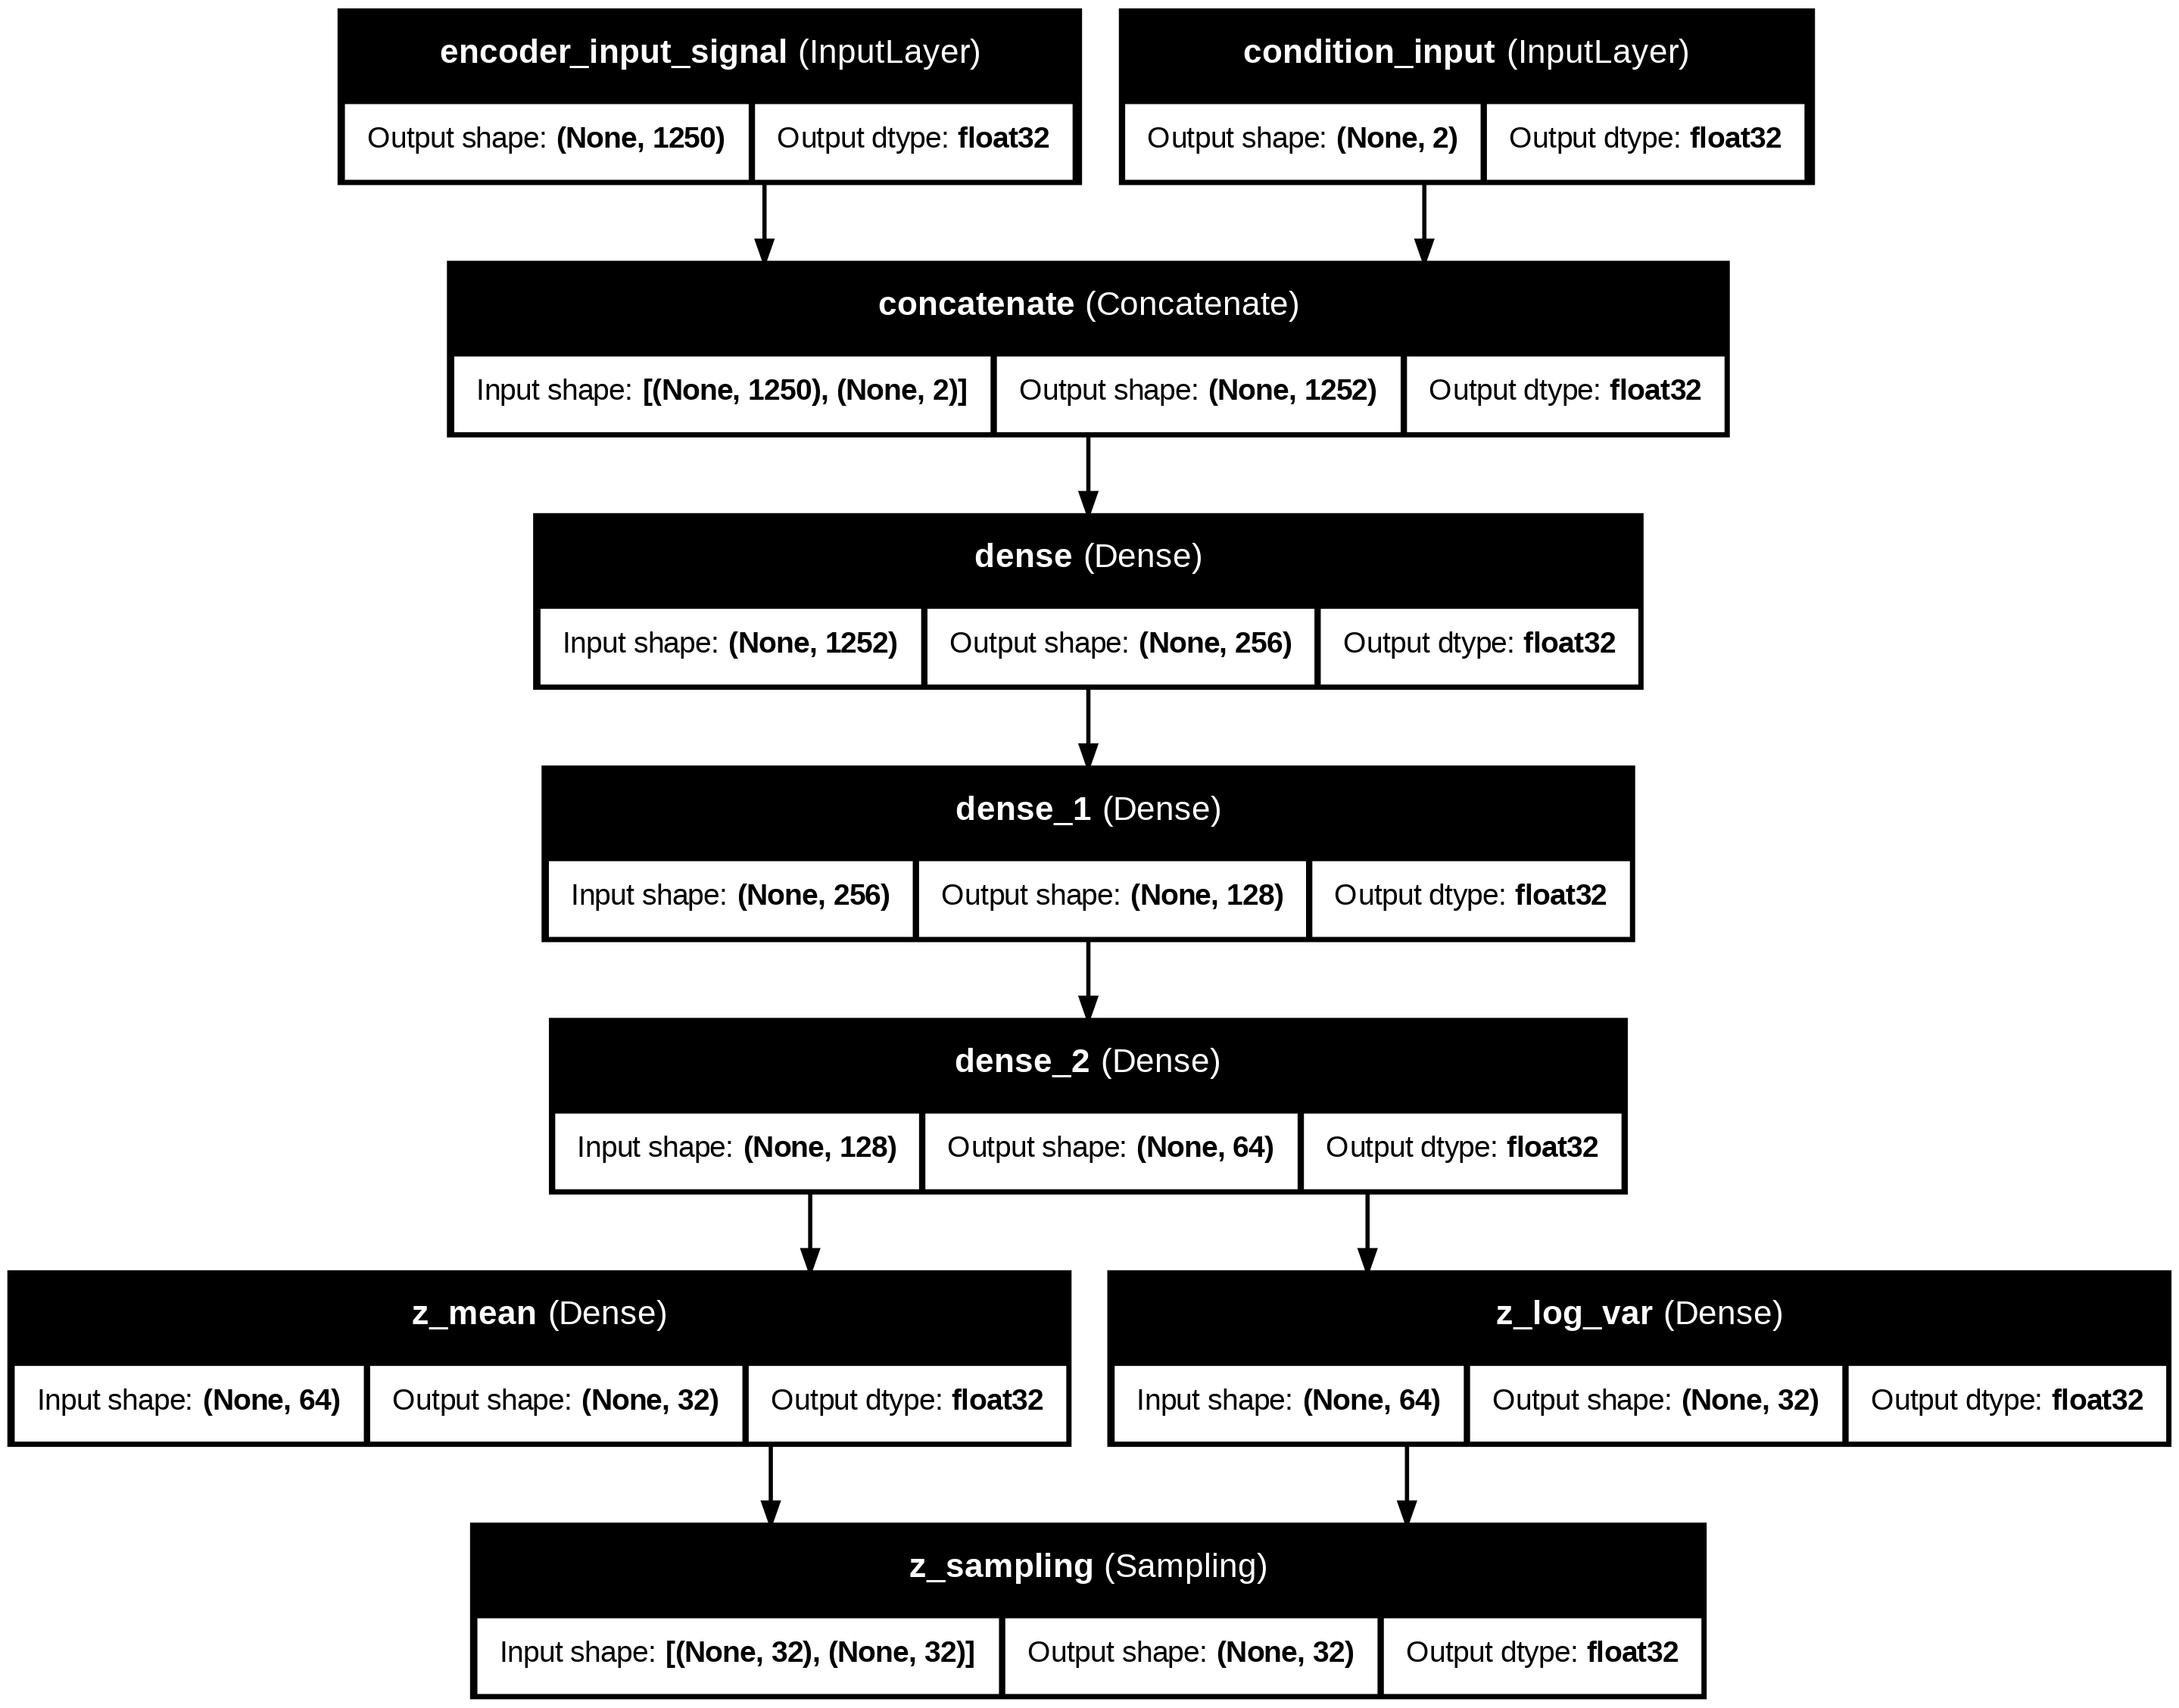

In [39]:
# from IPython.display import Image
from tensorflow.keras.utils import plot_model

plot_model(encoder,show_shapes=True, show_dtype=True, show_layer_names=True)

In [ ]:
path_img = os.path.join(model_path, 'encoder_architecture.png')
try:
    plot_model(encoder, to_file=path_img,
               show_shapes=True, show_dtype=True, show_layer_names=True)
    print("Encoder model structure saved to 'models/encoder_architecture.png'")
except Exception as e:
    print(f"Could not save model structure: {e}")

Encoder model structure saved to 'models/encoder_architecture.png'


### 4.3. Xây dựng Decoder

In [80]:
def build_decoder(latent_dim=20, condition_dim=2, output_dim=1250):
    """Xây dựng mạng Decoder theo mô tả."""
    # Đầu vào không gian tiềm ẩn z [batch_size, latent_dim]
    latent_inputs = layers.Input(shape=(latent_dim,), name='latent_input')

    # Đầu vào điều kiện HR và BR [batch_size, condition_dim]
    condition_inputs = layers.Input(shape=(condition_dim,), name='condition_input')

    # Ghép nối z với HR và BR → [batch_size, 22] (latent_dim=20, condition_dim=2)
    x = layers.Concatenate()([latent_inputs, condition_inputs])  # [batch_size, 22]

    x = layers.Dense(64, activation="sigmoid")(x)
    x = layers.Dense(128, activation="sigmoid")(x)
    x = layers.Dense(256, activation="relu")(x)

    # Lớp Dense: 1250 units, activation sigmoid (tái tạo tín hiệu PPG)
    decoder_outputs = layers.Dense(output_dim, activation='tanh', name='decoder_output_signal')(x)  # [batch_size, 1250]

    # Tạo mô hình Decoder
    decoder = Model([latent_inputs, condition_inputs], decoder_outputs, name='decoder')
    return decoder

# Tạo mô hình decoder
decoder = build_decoder(32,2,1250)

# Hiển thị cấu trúc decoder để kiểm tra
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer) │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ condition_input           │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 34)             │              0 │ latent_input[0][0],    │
│ (Concatenate)             │                        │                │ condition_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          2,240 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │          8,320 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 256)            │         33,024 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_output_signal     │ (None, 1250)           │        321,250 │ dense_11[0][0]         │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 364,834 (1.39 MB)

 Trainable params: 364,834 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

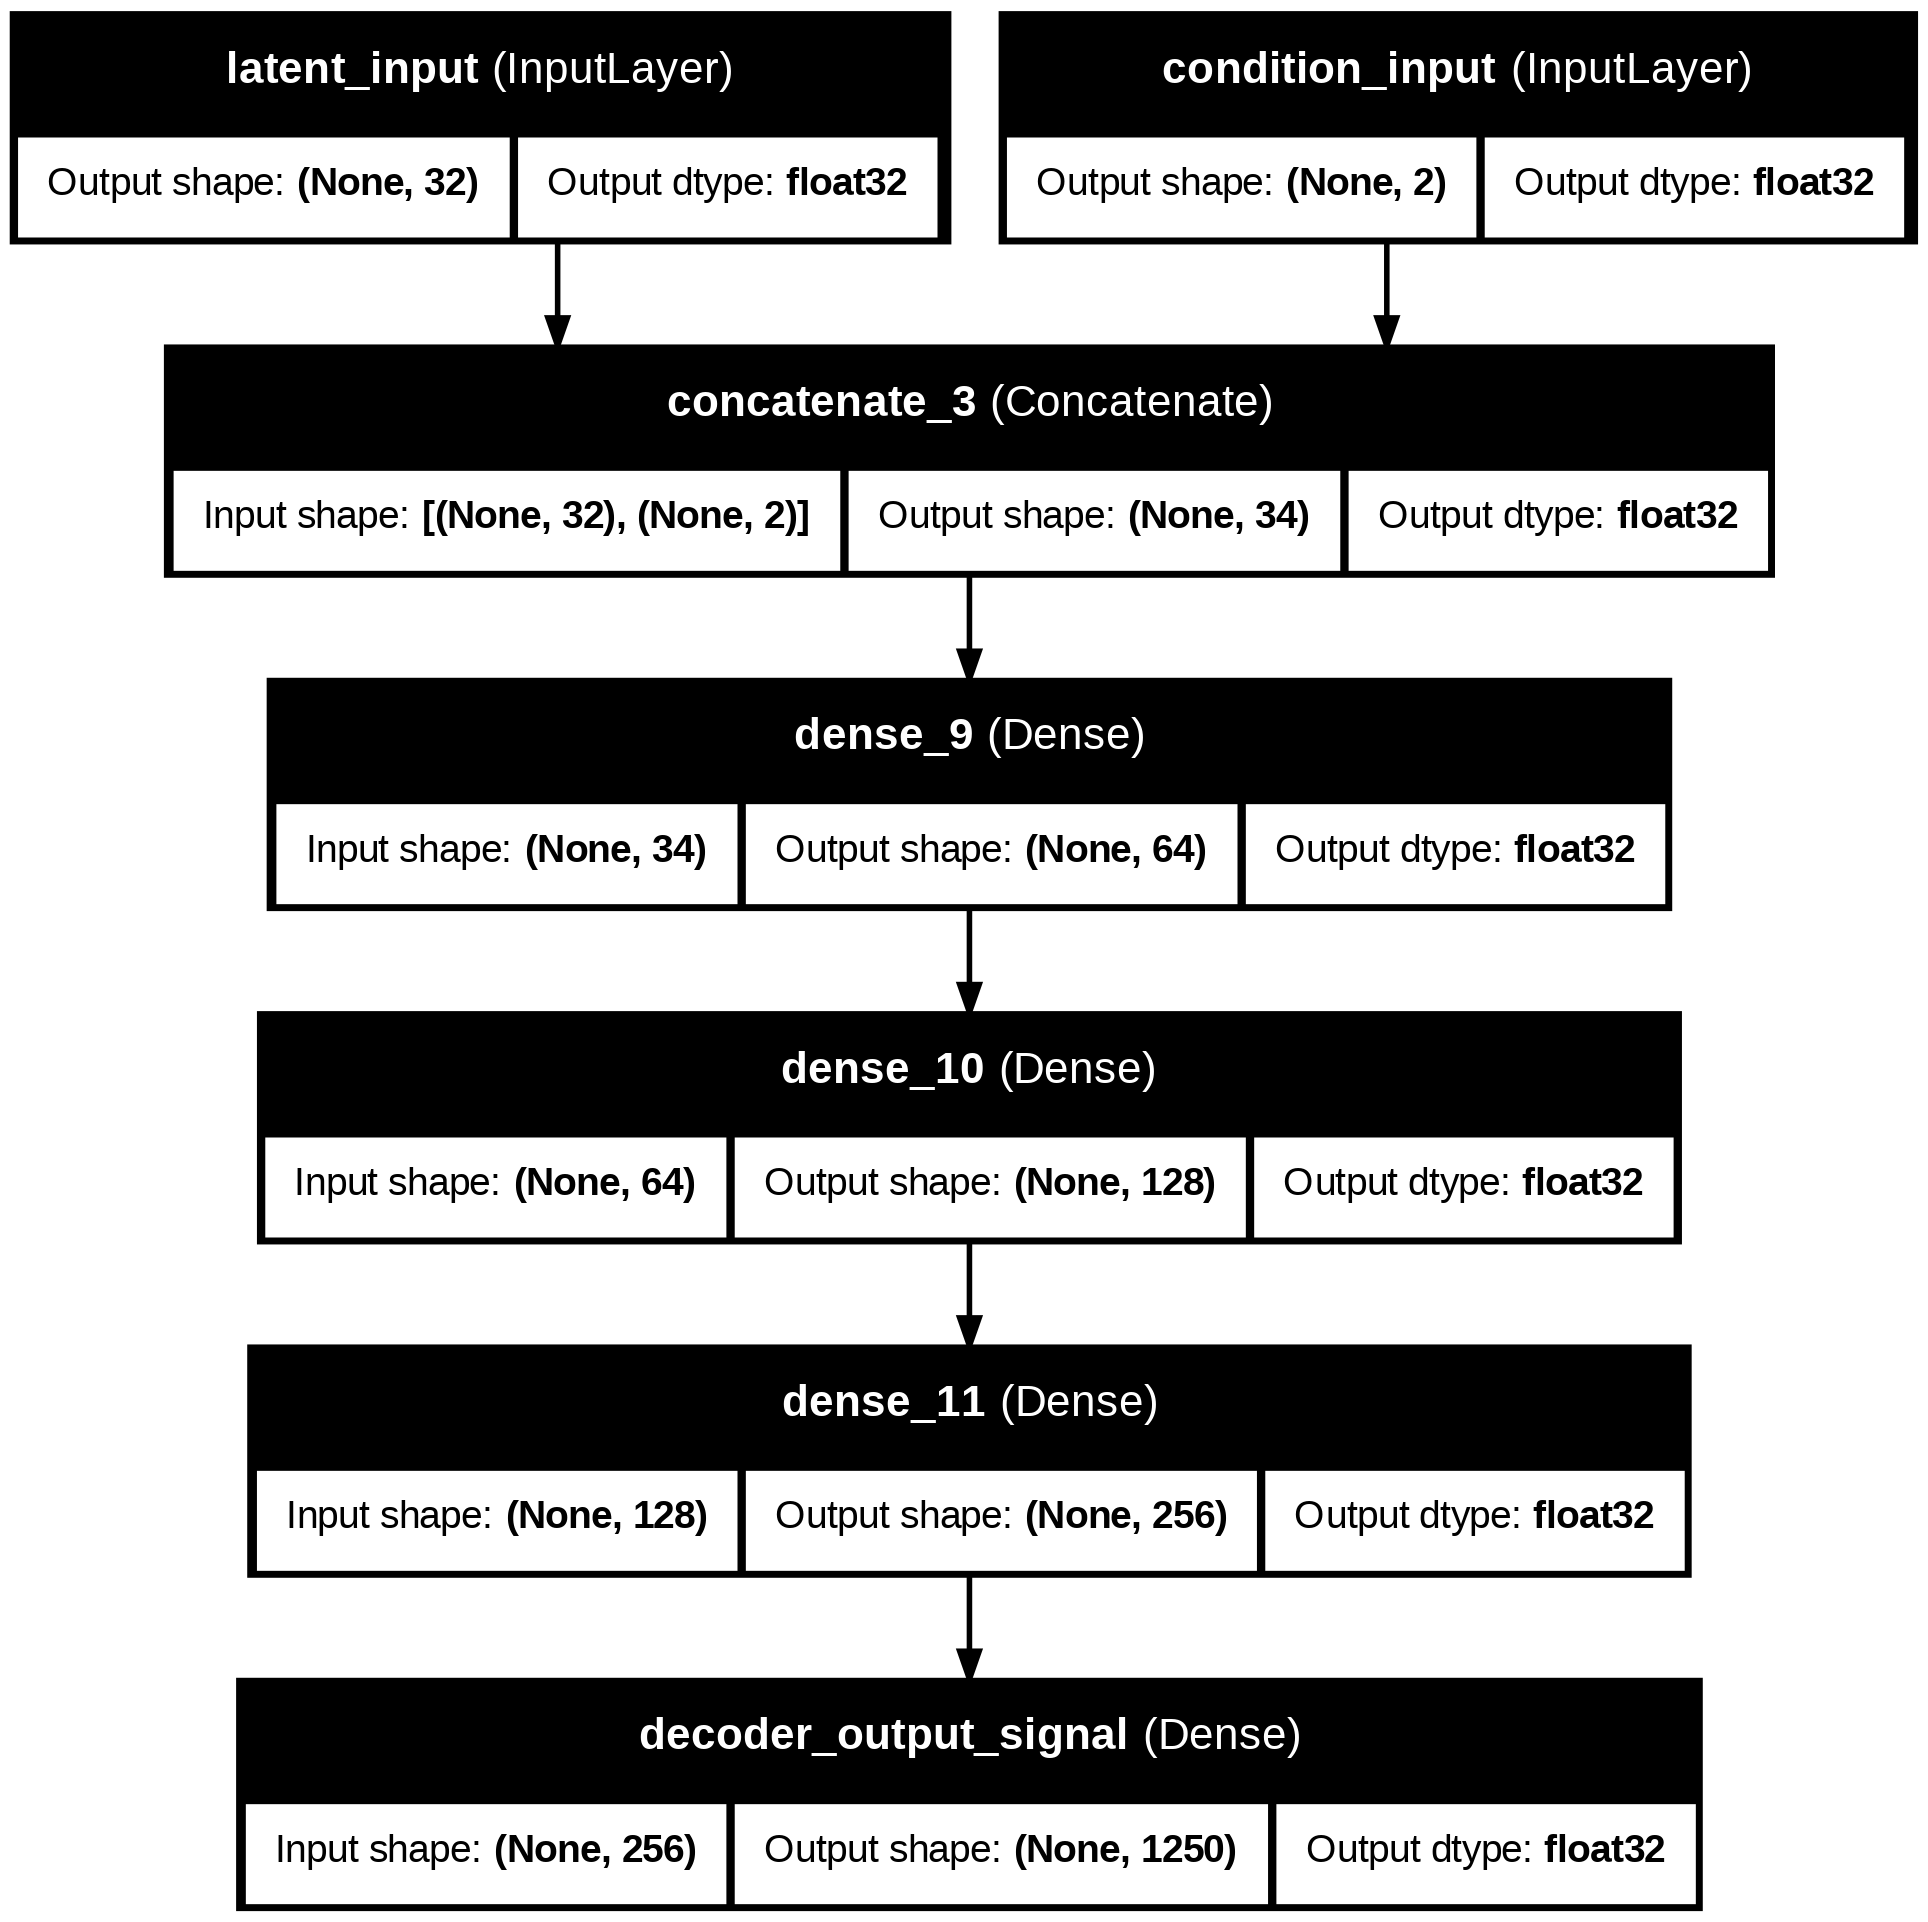

In [ ]:
# from IPython.display import Image
from tensorflow.keras.utils import plot_model

plot_model(decoder,show_shapes=True, show_dtype=True, show_layer_names=True)

In [ ]:
path_img = os.path.join(model_path, 'decoder_architecture.png')
try:
    plot_model(decoder, to_file=path_img,
               show_shapes=True, show_dtype=True, show_layer_names=True)
    print("Decoder model structure saved to 'models/decoder_architecture.png'")
except Exception as e:
    print(f"Could not save model structure: {e}")

Decoder model structure saved to 'models/decoder_architecture.png'


### 4.4. Tạo mô hình CVAE hoàn chỉnh

In [81]:
class CVAE_Combined(Model):
    """Conditional Variational Autoencoder kết hợp Encoder và Decoder."""
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE_Combined, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        # Định nghĩa đầu vào của mô hình tổng thể
        self.encoder_inputs = layers.Input(shape=(1250,), name='input_signal')
        self.condition_inputs = layers.Input(shape=(2,), name='condition_input')

        # Tạo luồng dữ liệu
        z_mean, z_log_var, z = self.encoder([self.encoder_inputs, self.condition_inputs])
        self.decoder_outputs = self.decoder([z, self.condition_inputs])

        # Định nghĩa mô hình tổng thể
        self._model = Model(inputs=[self.encoder_inputs, self.condition_inputs],
                           outputs=self.decoder_outputs, name='cvae_combined')

    @property
    def metrics(self):
        # Trả về danh sách các metrics để Keras theo dõi và hiển thị
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """Một bước huấn luyện."""
        # Giải nén dữ liệu đầu vào (tín hiệu PPG và điều kiện HR/RR)
        if isinstance(data, tuple) and len(data) == 2:
            x, condition = data
        else: # Xử lý trường hợp dataset chỉ trả về một tensor (ví dụ khi không có y)
            x = data
            # Giả định bạn cần tạo condition giả nếu không được cung cấp
            # HOẶC lấy condition từ một nguồn khác nếu logic yêu cầu
            # Ví dụ đơn giản: tạo condition zeros (cần điều chỉnh nếu logic khác)
            # condition = tf.zeros((tf.shape(x)[0], condition_dim), dtype=tf.float32)
            # ---> Trong trường hợp này, dataset đã được tạo với (x, condition) nên luôn là tuple
            print("Cảnh báo: Dữ liệu đầu vào train_step không như mong đợi (cần tuple (x, condition)).")
             # Tạm dừng để tránh lỗi không mong muốn
            return {m.name: tf.constant(0.0) for m in self.metrics}


        # Sử dụng GradientTape để tự động tính đạo hàm
        with tf.GradientTape() as tape:
            # Đưa dữ liệu qua Encoder
            z_mean, z_log_var, z = self.encoder([x, condition], training=True)
            # Đưa z và condition qua Decoder để tái tạo tín hiệu

            reconstruction = self.decoder([z, condition], training=True)

            # Tính Reconstruction Loss (ví dụ: Mean Squared Error)
            # Tính tổng MSE trên chiều tín hiệu (axis=1), sau đó lấy trung bình theo batch

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(x - reconstruction), axis=1)
            )

            # Tính KL Divergence Loss
            # Công thức: -0.5 * sum(1 + z_log_var - square(z_mean) - exp(z_log_var))
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            # Lấy giá trị beta hiện tại cho KL Annealing
            current_beta = 1.0

            # Tính Total Loss = Reconstruction Loss + beta * KL Loss
            total_loss = reconstruction_loss + current_beta * kl_loss

        # Tính gradients của total_loss theo các tham số có thể huấn luyện
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Cập nhật trọng số của model bằng optimizer
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Cập nhật trạng thái của các metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Trả về dictionary chứa giá trị hiện tại của các metrics
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Một bước đánh giá (tương tự train_step nhưng không cập nhật trọng số)."""
        if isinstance(data, tuple) and len(data) == 2:
            x, condition = data
        else:
             print("Cảnh báo: Dữ liệu đầu vào test_step không như mong đợi.")
             return {m.name: tf.constant(0.0) for m in self.metrics}


        # Đưa dữ liệu qua model (training=False)
        z_mean, z_log_var, z = self.encoder([x, condition], training=False)
        # z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
        reconstruction = self.decoder([z, condition], training=False)

        # Tính các loss
        reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(x - reconstruction), axis=1)
           )
        kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

        # Lấy beta hiện tại (quan trọng để loss validation khớp với loss training)
        current_beta = 1.0
        total_loss = reconstruction_loss + current_beta * kl_loss

        # Cập nhật trạng thái các metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Trả về dictionary metrics
        return {m.name: m.result() for m in self.metrics}
    def call(self, inputs, training=False):
      x, condition = inputs
      z_mean, z_log_var, z = self.encoder([x, condition], training=training)
      reconstruction = self.decoder([z, condition], training=training)
      return reconstruction
cvae = CVAE_Combined(encoder, decoder)
cvae.compile(optimizer=Adam(learning_rate=0.001))

### 4.5. Huấn luyện mô hình

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_total_loss',
    patience=20,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_path, 'cvae_checkpoint.keras'),
    save_best_only=True,
    monitor='val_total_loss',
    verbose=1
)

In [ ]:
csv_logger = keras.callbacks.CSVLogger(os.path.join(model_path, 'cvae_training_log.csv'))

In [ ]:
try:
    print(f"Đang tải dữ liệu huấn luyện từ: {processed_data_path}")
    X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
    # LƯU Ý QUAN TRỌNG: Load condition_train_raw.npy chứa giá trị HR/RR GỐC
    condition_train = np.load(os.path.join(processed_data_path, 'condition_train_raw.npy'))

    X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
    # Load condition_test_raw.npy chứa giá trị HR/RR GỐC cho tập validation
    condition_test = np.load(os.path.join(processed_data_path, 'condition_test_raw.npy'))

    print("Tải dữ liệu huấn luyện và kiểm thử thành công.")
    print(f" - X_train shape: {X_train.shape}, condition_train shape: {condition_train.shape}")
    print(f" - X_test shape: {X_test.shape}, condition_test shape: {condition_test.shape}")

    # Kiểm tra số mẫu khớp nhau
    assert X_train.shape[0] == condition_train.shape[0], "Số mẫu X_train và condition_train không khớp!"
    assert X_test.shape[0] == condition_test.shape[0], "Số mẫu X_test và condition_test không khớp!"


except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file dữ liệu .npy trong {processed_data_path}.")
    print("Hãy đảm bảo bạn đã chạy thành công ô Tiền xử lý trước.")
    # Dừng thực thi ở đây nếu không có dữ liệu
    raise
except Exception as e:
    print(f"Lỗi khi tải dữ liệu .npy: {e}")
    raise


Đang tải dữ liệu huấn luyện từ: drive/MyDrive/KQGK/processed
Tải dữ liệu huấn luyện và kiểm thử thành công.
 - X_train shape: (2275, 1250), condition_train shape: (2275, 2)
 - X_test shape: (569, 1250), condition_test shape: (569, 2)


In [ ]:
# Tạo dataset cho training
buffer_size = X_train.shape[0]
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, condition_train))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
# Prefetch để tối ưu pipeline dữ liệu
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(f" - Train dataset: Batch size={batch_size}, Shuffle buffer={buffer_size}")

# Tạo dataset cho validation/testing
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, condition_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
print(f" - Test dataset: Batch size={batch_size}")

 - Train dataset: Batch size=64, Shuffle buffer=2275
 - Test dataset: Batch size=64


In [ ]:
epochs = 1000
history = cvae.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset, # Dùng test_dataset làm validation data
        callbacks=[early_stopping, checkpoint, csv_logger],
        verbose=1
    )

if early_stopping.stopped_epoch > 0:
      print(f"Early stopping đã dừng huấn luyện tại epoch: {early_stopping.stopped_epoch + 1}")
      print(f"Trọng số tốt nhất từ epoch ~{early_stopping.stopped_epoch + 1 - early_stopping.patience} đã được khôi phục.")
else:
      # Nếu không dừng sớm, epoch tốt nhất là epoch cuối cùng lưu bởi ModelCheckpoint
      print(f"Huấn luyện hoàn thành {epochs} epochs hoặc ModelCheckpoint đã lưu trọng số tốt nhất.")

Epoch 1/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - kl_loss: 0.8002 - reconstruction_loss: 381.7541 - total_loss: 382.5543
Epoch 1: val_total_loss improved from inf to 368.18497, saving model to drive/MyDrive/KQGK/models/cvae_checkpoint.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - kl_loss: 0.7852 - reconstruction_loss: 381.4246 - total_loss: 382.2098 - val_kl_loss: 0.0243 - val_reconstruction_loss: 368.1607 - val_total_loss: 368.1850
Epoch 2/1000
20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.0337 - reconstruction_loss: 363.5125 - total_loss: 363.5462 
Epoch 2: val_total_loss improved from 368.18497 to 367.88812, saving model to drive/MyDrive/KQGK/models/cvae_checkpoint.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0444 - reconstruction_loss: 363.0977 - total_loss: 363.1421 - val_kl_loss: 0.1806 - val_reconstruction_loss: 367.7076 - val_total_loss: 367.8881
Epoch 3/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 0.5349 - reconstruction_loss: 362.1942 - total_loss: 362.7291
Epoch 3: val_total_loss improved from 367.88812 to 361.86096, saving model to drive/MyDrive/KQGK/models/cvae_checkpoint.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.5504 - reconstruction_loss: 362.1328 - total_los

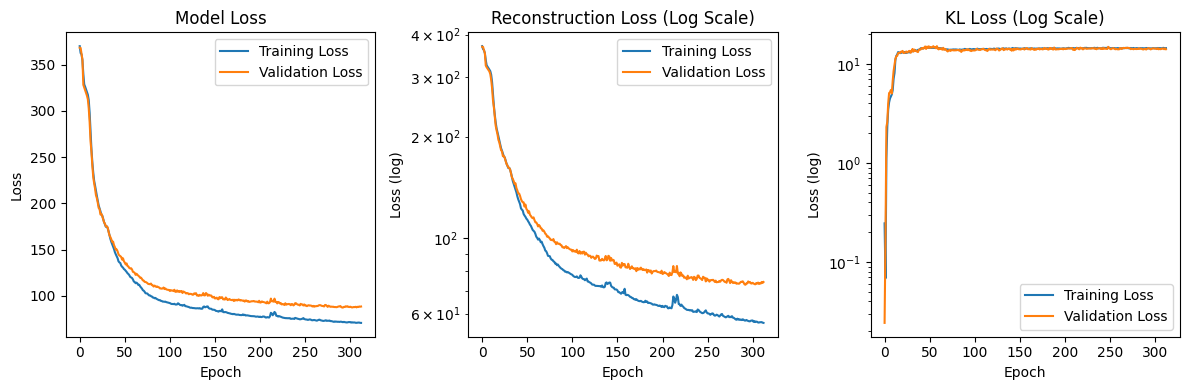

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['total_loss'], label='Training Loss')
plt.plot(history.history['val_total_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='Training Loss')
plt.plot(history.history['val_reconstruction_loss'], label='Validation Loss')
plt.title('Reconstruction Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'], label='Training Loss')
plt.plot(history.history['val_kl_loss'], label='Validation Loss')
plt.title('KL Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
path_his = os.path.join(model_path, 'history.png')
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['total_loss'], label='Training Loss')
plt.plot(history.history['val_total_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='Training Loss')
plt.plot(history.history['val_reconstruction_loss'], label='Validation Loss')
plt.title('Reconstruction Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'], label='Training Loss')
plt.plot(history.history['val_kl_loss'], label='Validation Loss')
plt.title('KL Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(path_his)
plt.close()

In [ ]:
cvae.save(os.path.join(model_path, 'cvae_model1.keras'))
encoder.save(os.path.join(model_path, 'encoder.keras'))
decoder.save(os.path.join(model_path, 'decoder.keras'))
print("Models saved successfully.")

Models saved successfully.


### 4.6. Tạo dữ liệu mới từ mô hình đã huấn luyện

In [82]:
hr_mean = np.load(os.path.join(processed_data_path, 'hr_mean.npy'))
hr_std = np.load(os.path.join(processed_data_path, 'hr_std.npy'))
rr_mean = np.load(os.path.join(processed_data_path, 'rr_mean.npy'))
rr_std = np.load(os.path.join(processed_data_path, 'rr_std.npy'))

In [83]:
def generate_ppg(hr, rr, num_samples=5):
    """
    Tạo tín hiệu PPG mới từ HR và RR cho trước.

    Parameters:
    -----------
    hr : float
        Nhịp tim (bpm)
    rr : float
        Tốc độ hô hấp (bpm)
    num_samples : int
        Số lượng mẫu cần tạo

    Returns:
    --------
    tuple
        (normalized_ppg, original_scale_ppg)
    """
    # Chuẩn hóa điều kiện sử dụng z-score với thông số đã lưu
    hr_norm = (hr - hr_mean) / hr_std
    rr_norm = (rr - rr_mean) / rr_std
    conditions = np.array([[hr_norm, rr_norm]] * num_samples)

    # Tạo vector ngẫu nhiên trong không gian tiềm ẩn
    z = np.random.normal(size=(num_samples, 32))

    # Tạo tín hiệu PPG mới
    generated_ppg_norm = decoder.predict([z, conditions])
    original_scale_ppg = normalize_to_range(generated_ppg_norm,-1,1)

    return generated_ppg_norm,original_scale_ppg

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Generated normalized PPG shape: (5, 1250)


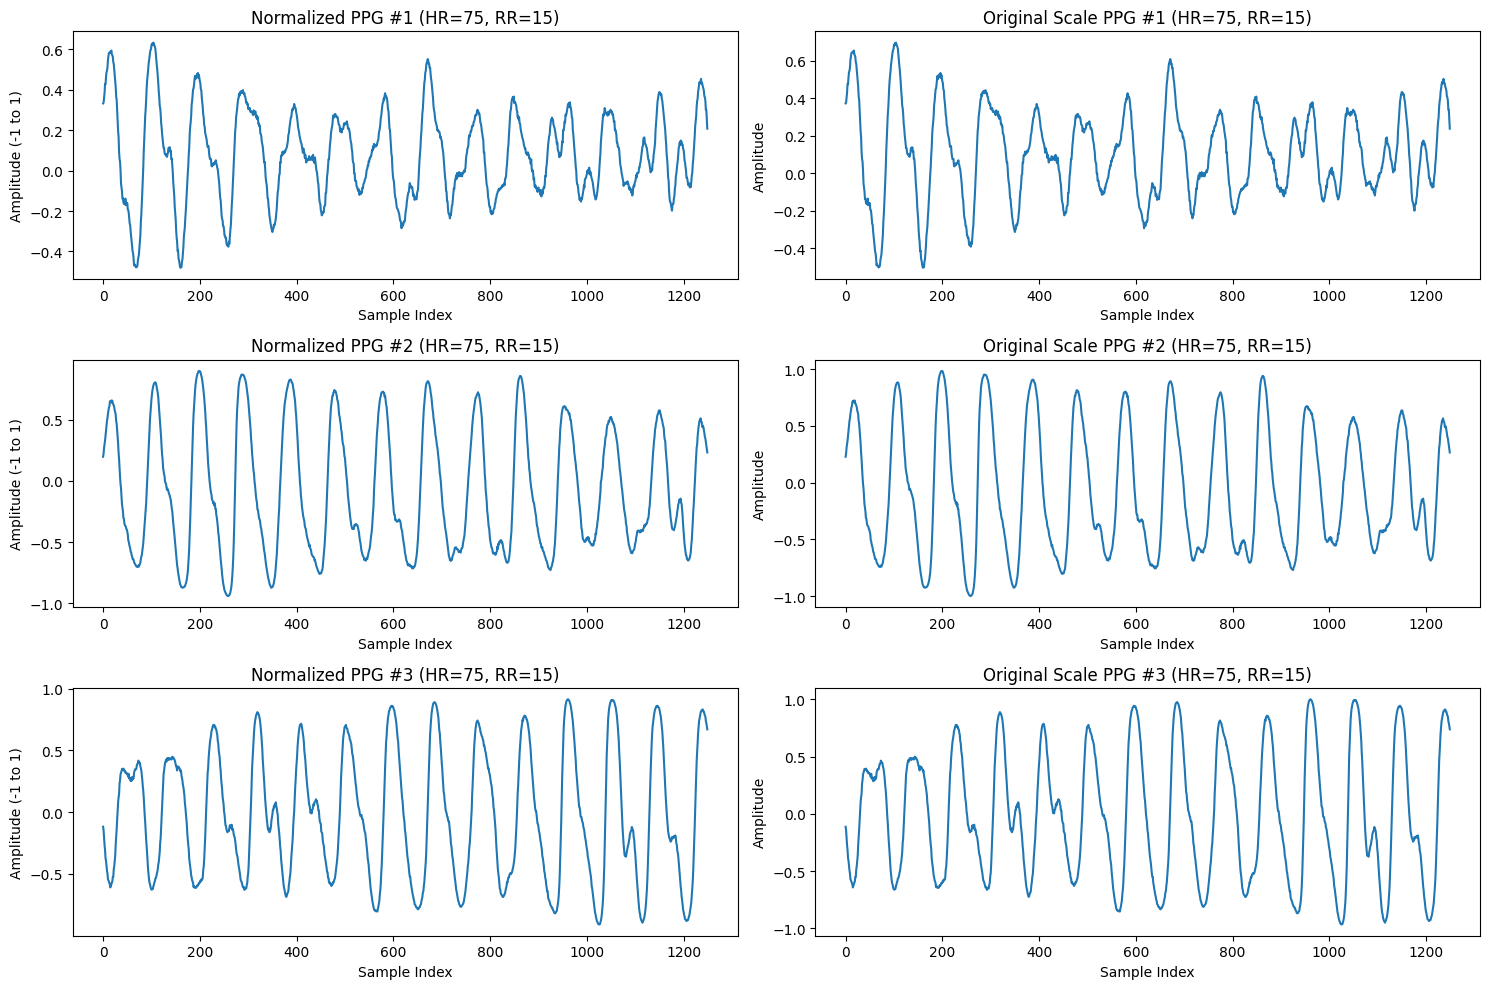

In [ ]:
#Kiểm tra hàm tạo dữ liệu
hr_test = 75
rr_test = 15
generated_ppg_norm,generated_ppg_orig = generate_ppg(hr_test, rr_test, num_samples=5)

# Hiển thị kết quả
print(f"Generated normalized PPG shape: {generated_ppg_orig.shape}")
plt.figure(figsize=(15, 10))
for i in range(3):
    # Vẽ tín hiệu chuẩn hóa
    plt.subplot(3, 2, i*2+1)
    plt.plot(generated_ppg_norm[i])
    plt.title(f'Normalized PPG #{i+1} (HR={hr_test}, RR={rr_test})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude (-1 to 1)')

    # Vẽ tín hiệu theo thang đo gốc
    plt.subplot(3, 2, i*2+2)
    plt.plot(generated_ppg_orig[i])
    plt.title(f'Original Scale PPG #{i+1} (HR={hr_test}, RR={rr_test})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [ ]:
#Kiểm tra hàm tạo dữ liệu
hr_test = 75
rr_test = 15
generated_ppg_norm,generated_ppg_orig = generate_ppg(hr_test, rr_test, num_samples=5)

# Hiển thị kết quả
print(f"Generated normalized PPG shape: {generated_ppg_orig.shape}")
plt.figure(figsize=(15, 10))
for i in range(3):
    # Vẽ tín hiệu chuẩn hóa
    plt.subplot(3, 2, i*2+1)
    plt.plot(generated_ppg_norm[i])
    plt.title(f'Normalized PPG #{i+1} (HR={hr_test}, RR={rr_test})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude (-1 to 1)')

    # Vẽ tín hiệu theo thang đo gốc
    plt.subplot(3, 2, i*2+2)
    plt.plot(generated_ppg_orig[i])
    plt.title(f'Original Scale PPG #{i+1} (HR={hr_test}, RR={rr_test})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.savefig(os.path.join(model_path, 'GEN.png'))
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Generated normalized PPG shape: (5, 1250)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


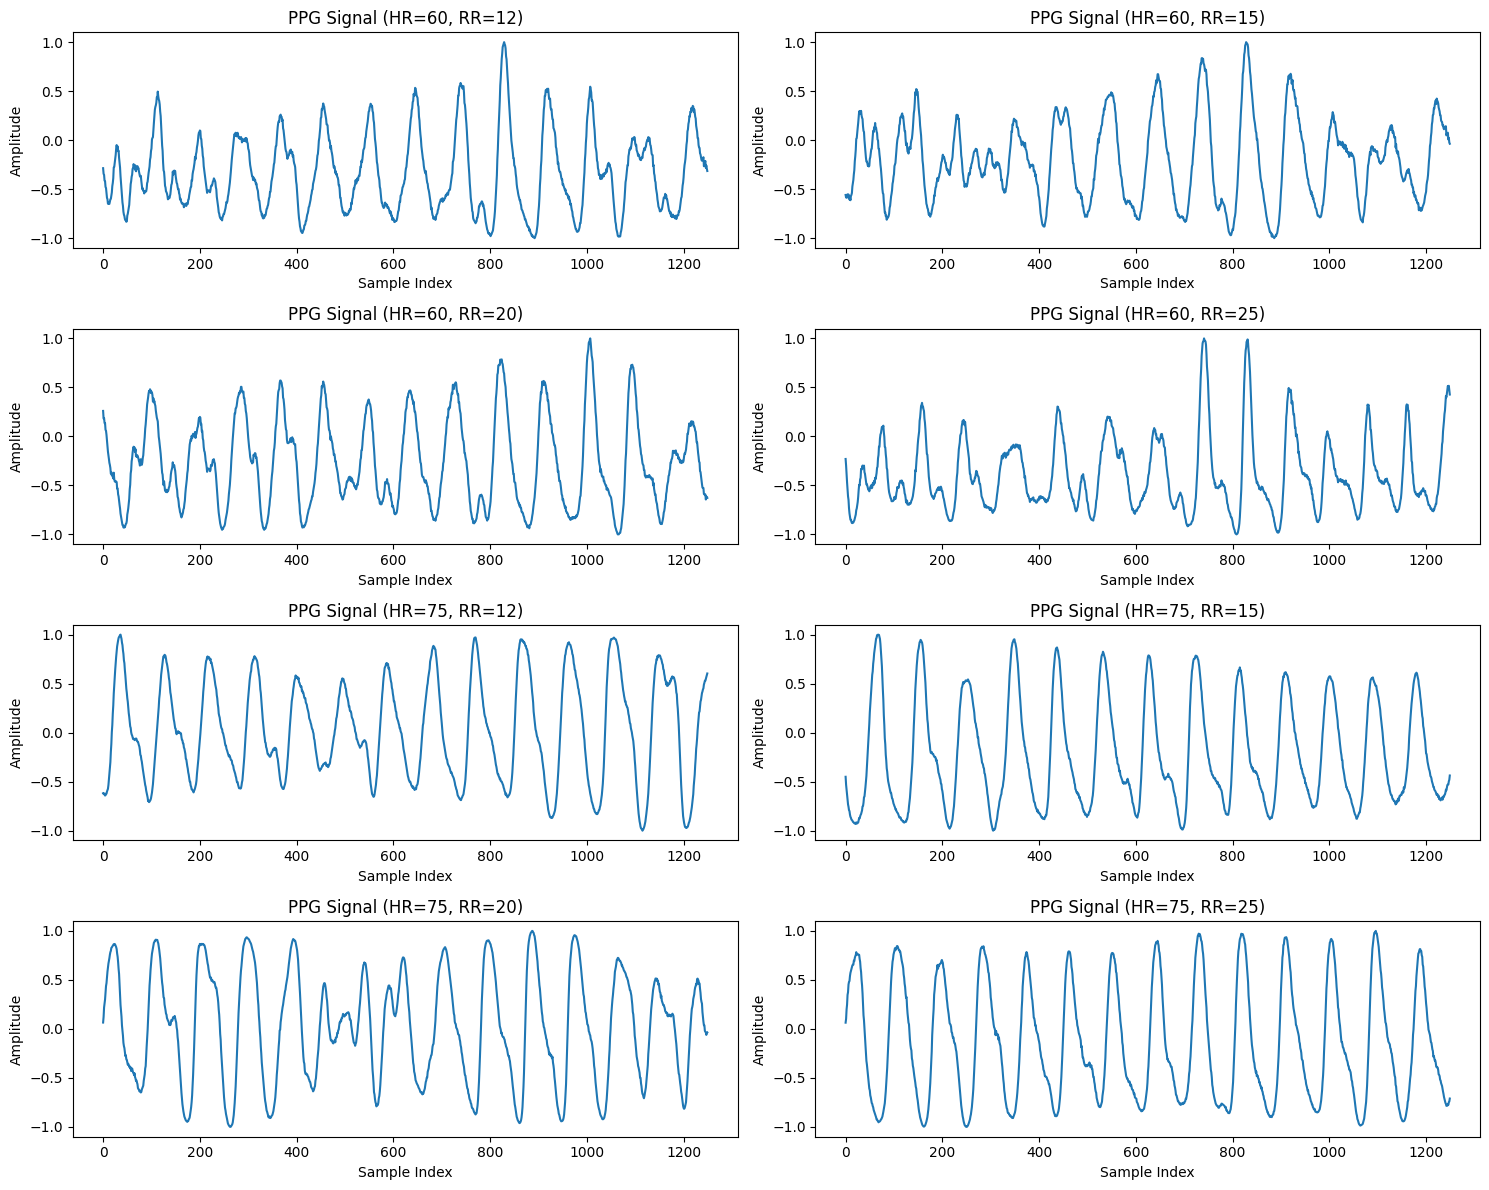

In [ ]:
# Tạo tín hiệu PPG với các giá trị HR và RR khác nhau
hr_values = [60, 75, 90, 120]
rr_values = [12, 15, 20, 25]

plt.figure(figsize=(15, 12))
plot_idx = 1

for hr in hr_values:
    for rr in rr_values:
        if plot_idx > 8:  # Chỉ vẽ 8 hình đầu tiên
            break

        # Tạo tín hiệu
        _,generated_ppg = generate_ppg(hr, rr, num_samples=1)

        # Vẽ tín hiệu
        plt.subplot(4, 2, plot_idx)
        plt.plot(generated_ppg[0])
        plt.title(f'PPG Signal (HR={hr}, RR={rr})')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')

        plot_idx += 1

plt.tight_layout()
plt.show()

In [ ]:
# Lưu một số mẫu tín hiệu để phân tích sau này
samples = {}
for hr in [60, 80, 100]:
    for rr in [12, 16, 20]:
        ppg = generate_ppg(hr, rr, num_samples=5)
        samples[(hr, rr)] = ppg

np.save(os.path.join(model_path, 'generated_ppg_samples.npy'), samples)
print("Generated PPG samples saved to 'models/generated_ppg_samples.npy'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Generated PPG samples saved to 'models/generated_ppg_samples.npy'


## 5. YÊU CẦU NÂNG CAO: XÂY DỰNG MÔ HÌNH CNN-CVAE

### 5.1. Chuẩn bị dữ liệu cho CNN

In [ ]:
try:
    print(f"Đang tải dữ liệu huấn luyện từ: {processed_data_path}")
    X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
    # LƯU Ý QUAN TRỌNG: Load condition_train_raw.npy chứa giá trị HR/RR GỐC
    condition_train = np.load(os.path.join(processed_data_path, 'condition_train_raw.npy'))

    X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
    # Load condition_test_raw.npy chứa giá trị HR/RR GỐC cho tập validation
    condition_test = np.load(os.path.join(processed_data_path, 'condition_test_raw.npy'))

    print("Tải dữ liệu huấn luyện và kiểm thử thành công.")
    print(f" - X_train shape: {X_train.shape}, condition_train shape: {condition_train.shape}")
    print(f" - X_test shape: {X_test.shape}, condition_test shape: {condition_test.shape}")

    # Kiểm tra số mẫu khớp nhau
    assert X_train.shape[0] == condition_train.shape[0], "Số mẫu X_train và condition_train không khớp!"
    assert X_test.shape[0] == condition_test.shape[0], "Số mẫu X_test và condition_test không khớp!"


except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file dữ liệu .npy trong {processed_data_path}.")
    print("Hãy đảm bảo bạn đã chạy thành công ô Tiền xử lý trước.")
    # Dừng thực thi ở đây nếu không có dữ liệu
    raise
except Exception as e:
    print(f"Lỗi khi tải dữ liệu .npy: {e}")
    raise

Đang tải dữ liệu huấn luyện từ: drive/MyDrive/KQGK/processed
Tải dữ liệu huấn luyện và kiểm thử thành công.
 - X_train shape: (2275, 1250), condition_train shape: (2275, 2)
 - X_test shape: (569, 1250), condition_test shape: (569, 2)


In [ ]:
# Tạo dataset cho training
buffer_size = X_train.shape[0]
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, condition_train))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
# Prefetch để tối ưu pipeline dữ liệu
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(f" - Train dataset: Batch size={batch_size}, Shuffle buffer={buffer_size}")

# Tạo dataset cho validation/testing
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, condition_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
print(f" - Test dataset: Batch size={batch_size}")

 - Train dataset: Batch size=64, Shuffle buffer=2275
 - Test dataset: Batch size=64


### 5.2. Xây dựng CNN Encoder

In [84]:
import keras
def build_encoder_cnn(input_dim=1250, condition_dim=2, latent_dim=20):
    """Xây dựng mạng Encoder đơn giản hóa với 2 lớp Conv1D."""
    # Đầu vào tín hiệu PPG [batch_size, 1250]
    encoder_inputs = layers.Input(shape=(input_dim, 1), name='encoder_input_signal')

    x = encoder_inputs  # [batch_size, 1250]

    # Đầu vào điều kiện HR và BR [batch_size, 2]
    condition_inputs = layers.Input(shape=(condition_dim,), name='condition_input')

    condition_repeated = layers.RepeatVector(input_dim)(condition_inputs)
    condition_reshaped = layers.Reshape((input_dim, 2))(condition_repeated)
    merged_input = layers.Concatenate(axis=2)([x, condition_reshaped])

    # Chỉ sử dụng 2 lớp Conv1D
    x = layers.Conv1D(32, kernel_size=15, strides=2, padding="same", activation="relu")(merged_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, kernel_size=11, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, condition_inputs])
    # Giảm số lớp Dense
    x = layers.Dense(128, activation="relu")(x)  # Chỉ giữ 1 lớp Dense trung gian

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model([encoder_inputs, condition_inputs], [z_mean, z_log_var, z], name='encoder')
    return encoder

# Tạo mô hình encoder
encoder =build_encoder_cnn(1250,2,32)

# Hiển thị cấu trúc encoder để kiểm tra
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ condition_input           │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 1250, 2)        │              0 │ condition_input[0][0]  │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_input_signal      │ (None, 1250, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1250, 2)        │              0 │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 1250, 3)        │              0 │ encoder_input_signal[… │
│ (Concatenate)             │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 625, 32)        │          1,472 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 625, 32)        │            128 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 313, 64)        │         22,592 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 313, 64)        │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 20032)          │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 20034)          │              0 │ flatten[0][0],         │
│ (Concatenate)             │                        │                │ condition_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 128)            │      2,564,480 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │          4,128 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │          4,128 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 32)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,597,184 (9.91 MB)

 Trainable params: 2,596,992 (9.91 MB)

 Non-trainable params: 192 (768.00 B)

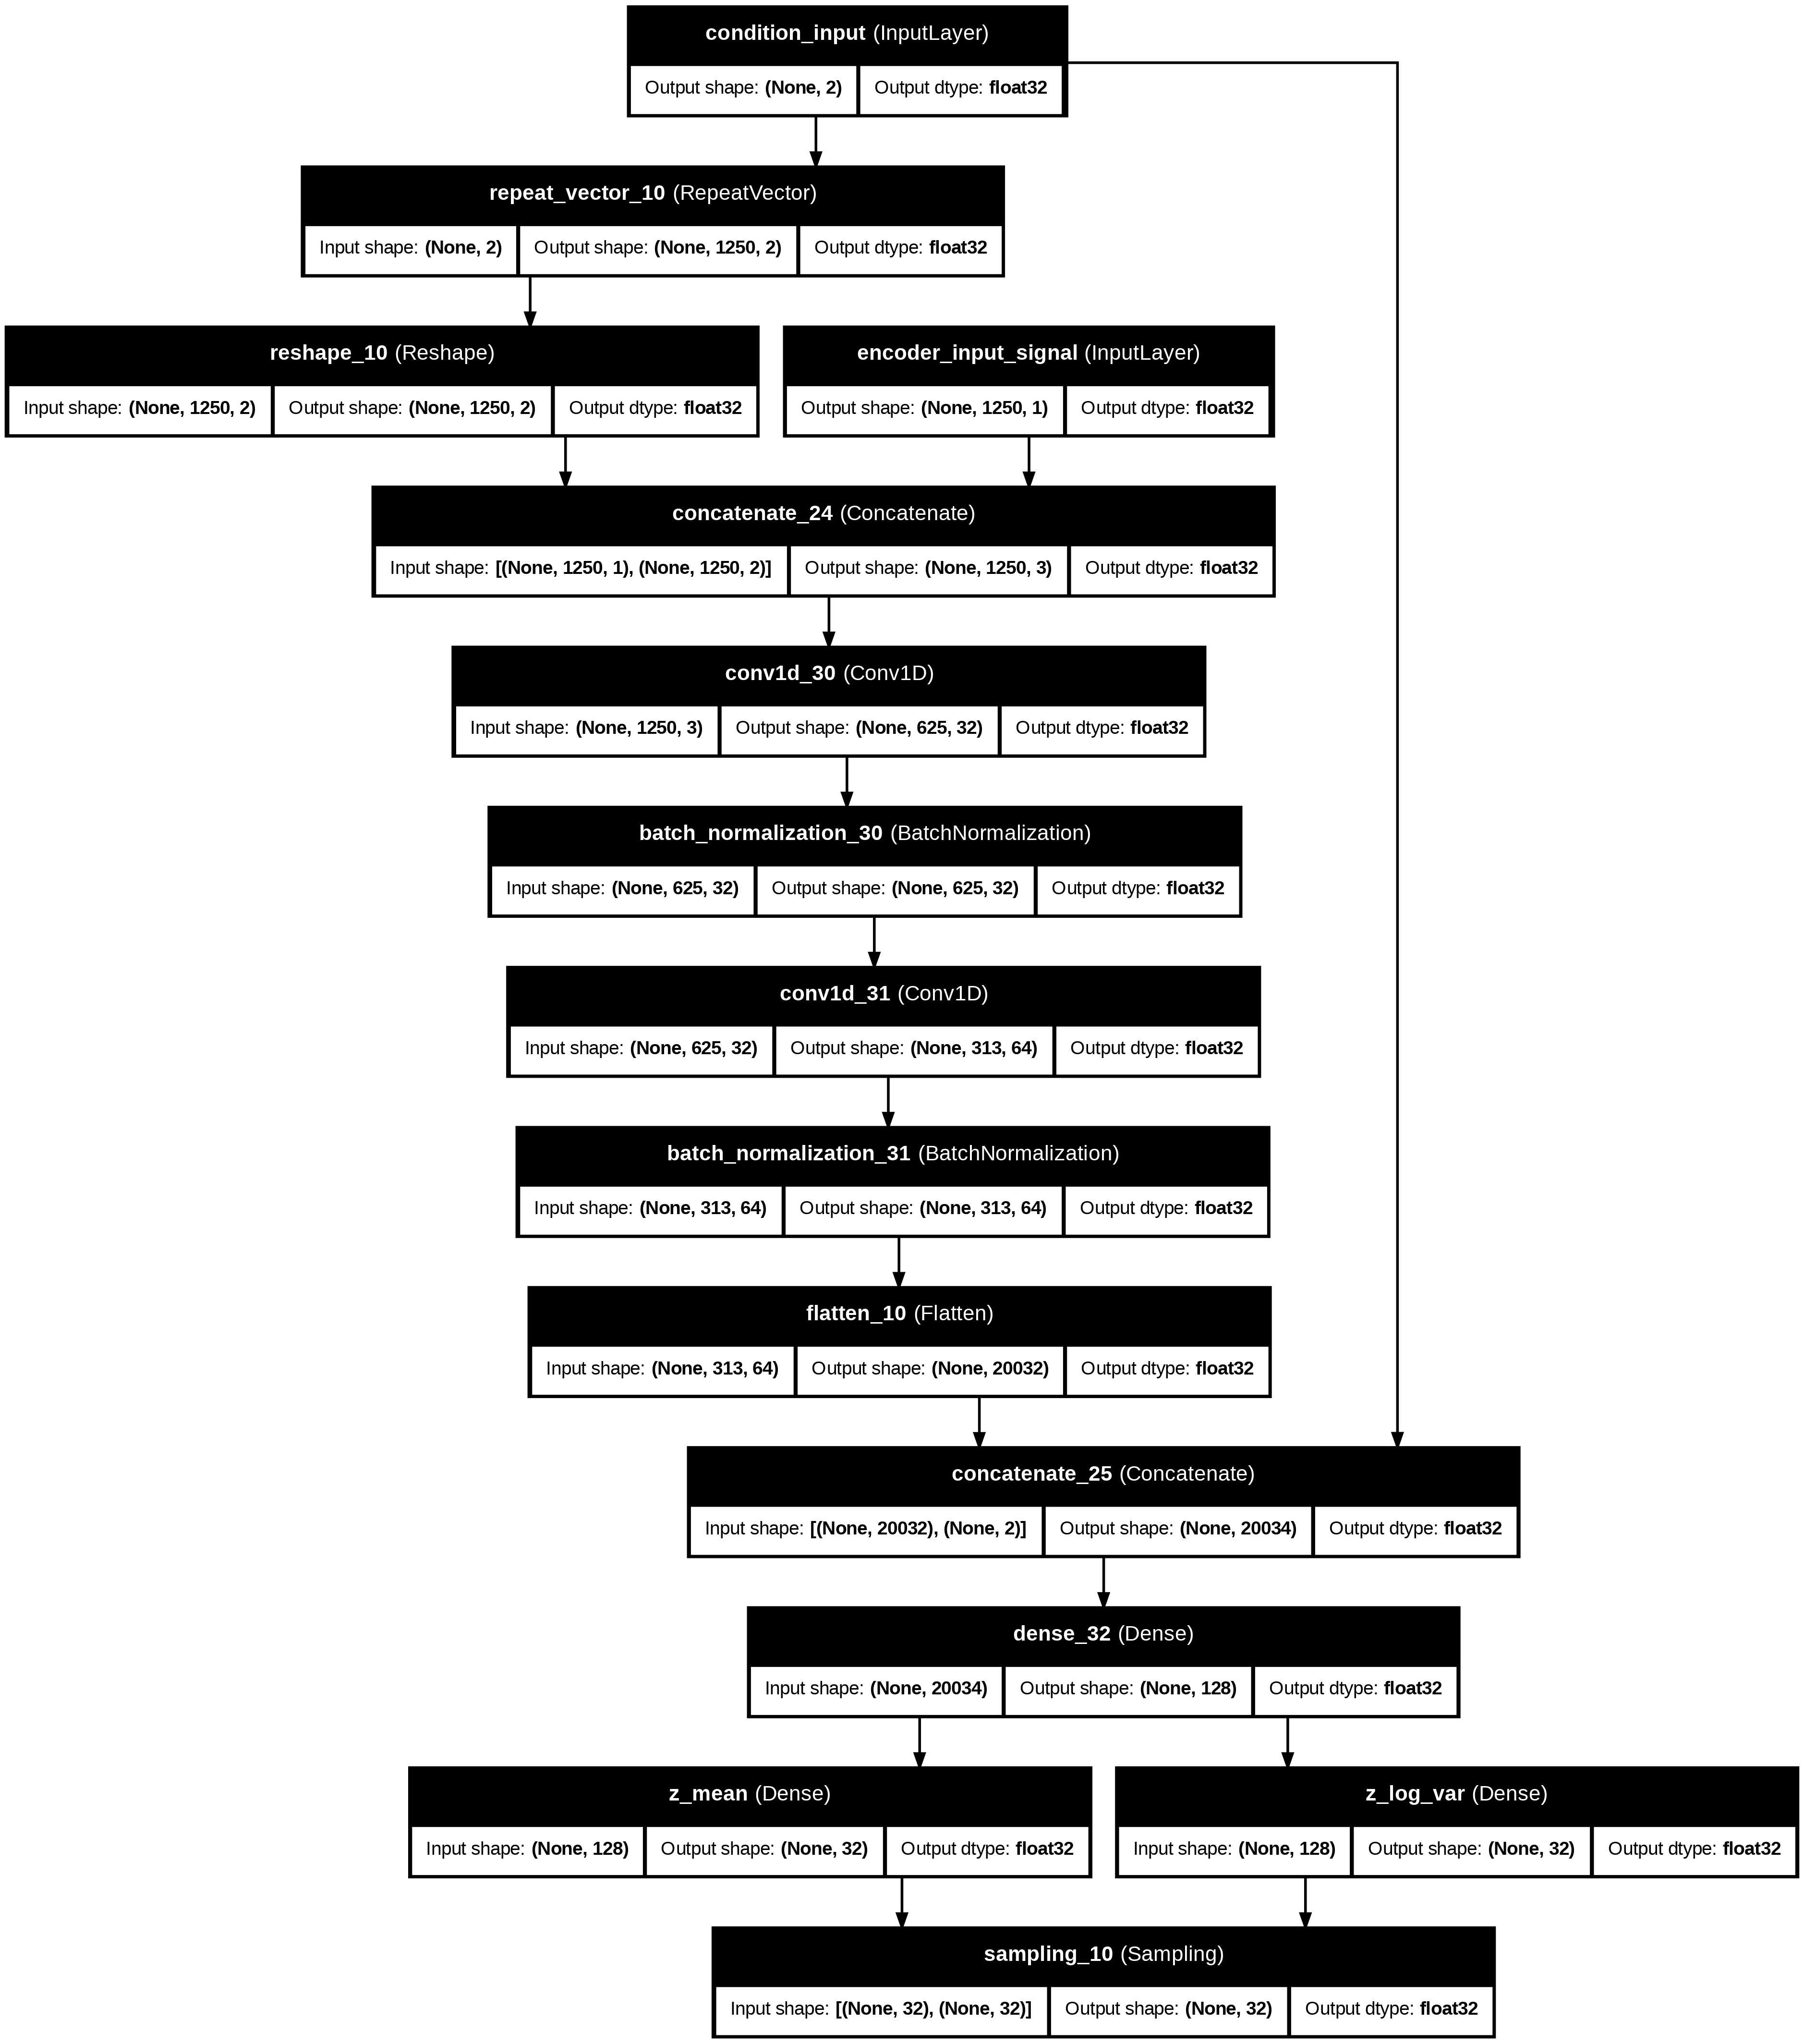

In [ ]:
# from IPython.display import Image
from tensorflow.keras.utils import plot_model

plot_model(encoder,show_shapes=True, show_dtype=True, show_layer_names=True)

In [ ]:
path_img = os.path.join(model_path, 'encoder_cnn_architecture.png')
try:
    plot_model(encoder, to_file=path_img,
               show_shapes=True, show_dtype=True, show_layer_names=True)
    print("Encoder model structure saved to 'models/encoder_cnn_architecture.png'")
except Exception as e:
    print(f"Could not save model structure: {e}")

Encoder model structure saved to 'models/encoder_cnn_architecture.png'


In [ ]:
#Kiểm tra cấu trúc các layer - đặc biệt quan trọng cho CNN
# Xem kích thước các feature map sau mỗi Conv1D
test_input_ppg = np.random.normal(size=(1, 1250, 1))
test_input_cond = np.random.normal(size=(1, 2))

feature_maps= encoder.predict([test_input_ppg, test_input_cond])
for i, feature_map in enumerate(feature_maps):
    print(f"Feature map {i} shape: {feature_map.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature map 0 shape: (1, 32)
Feature map 1 shape: (1, 32)
Feature map 2 shape: (1, 32)


### 5.3. Xây dựng CNN Decoder

In [85]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_decoder_cnn(latent_dim=32, condition_dim=2, output_dim=1250):
    """Xây dựng mạng Decoder đơn giản hóa để phù hợp với Encoder."""
    # Đầu vào latent [batch_size, latent_dim]
    latent_input = layers.Input(shape=(latent_dim,), name="latent_input")
    # Đầu vào điều kiện [batch_size, 2]
    decoder_condition_input = layers.Input(shape=(condition_dim,), name="decoder_condition_input")

    # Kết hợp latent và điều kiện
    decoder_inputs = layers.Concatenate()([latent_input, decoder_condition_input])

    # Lớp Dense để mở rộng kích thước
    x = layers.Dense(128, activation="relu")(decoder_inputs)
    x = layers.Dense(313 * 64, activation="relu")(x)  # 313 là chiều dài sau 2 lần giảm của encoder

    # Reshape để chuẩn bị cho Conv1DTranspose
    x = layers.Reshape((313, 64))(x)  # [batch_size, 313, 64]

    # Thêm điều kiện vào lớp đầu tiên
    condition_repeated = layers.RepeatVector(313)(decoder_condition_input)
    x = layers.Concatenate(axis=2)([x, condition_repeated])  # [batch_size, 313, 66]

    # Lớp Conv1DTranspose 1
    x = layers.Conv1DTranspose(32, kernel_size=11, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)  # [batch_size, 626, 32]

    # Thêm điều kiện vào lớp thứ hai
    condition_repeated = layers.RepeatVector(626)(decoder_condition_input)
    x = layers.Concatenate(axis=2)([x, condition_repeated])  # [batch_size, 626, 34]

    # Lớp Conv1DTranspose 2
    x = layers.Conv1DTranspose(16, kernel_size=15, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)  # [batch_size, 1252, 16]

    # Lớp đầu ra
    x = layers.Conv1D(1, kernel_size=1, padding="same", activation="tanh")(x)  # [batch_size, 1252, 1]

    # Cắt để đạt kích thước chính xác 1250
    decoder_outputs = layers.Cropping1D(cropping=(1, 1))(x)  # Cắt từ 1252 xuống 1250

    # Tạo mô hình decoder
    cnn_decoder = Model([latent_input, decoder_condition_input], decoder_outputs, name="cnn_decoder")

    return cnn_decoder

# Tạo mô hình decoder
decoder = build_decoder_cnn(latent_dim=32, condition_dim=2, output_dim=1250)

# Hiển thị cấu trúc decoder để kiểm tra
decoder.summary()

Model: "cnn_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer) │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_condition_input   │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 34)             │              0 │ latent_input[0][0],    │
│ (Concatenate)             │                        │                │ decoder_condition_inp… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │          4,480 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 20032)          │      2,584,128 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 313, 64)        │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 313, 2)         │              0 │ decoder_condition_inp… │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 313, 66)        │              0 │ reshape_1[0][0],       │
│ (Concatenate)             │                        │                │ repeat_vector_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_transpose          │ (None, 626, 32)        │         23,264 │ concatenate_7[0][0]    │
│ (Conv1DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 626, 32)        │            128 │ conv1d_transpose[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 626, 2)         │              0 │ decoder_condition_inp… │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 626, 34)        │              0 │ batch_normalization_2… │
│ (Concatenate)             │                        │                │ repeat_vector_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_transpose_1        │ (None, 1252, 16)       │          8,176 │ concatenate_8[0][0]    │
│ (Conv1DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 1252, 16)       │             64 │ conv1d_transpose_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)    

 Total params: 2,620,257 (10.00 MB)

 Trainable params: 2,620,161 (10.00 MB)

 Non-trainable params: 96 (384.00 B)

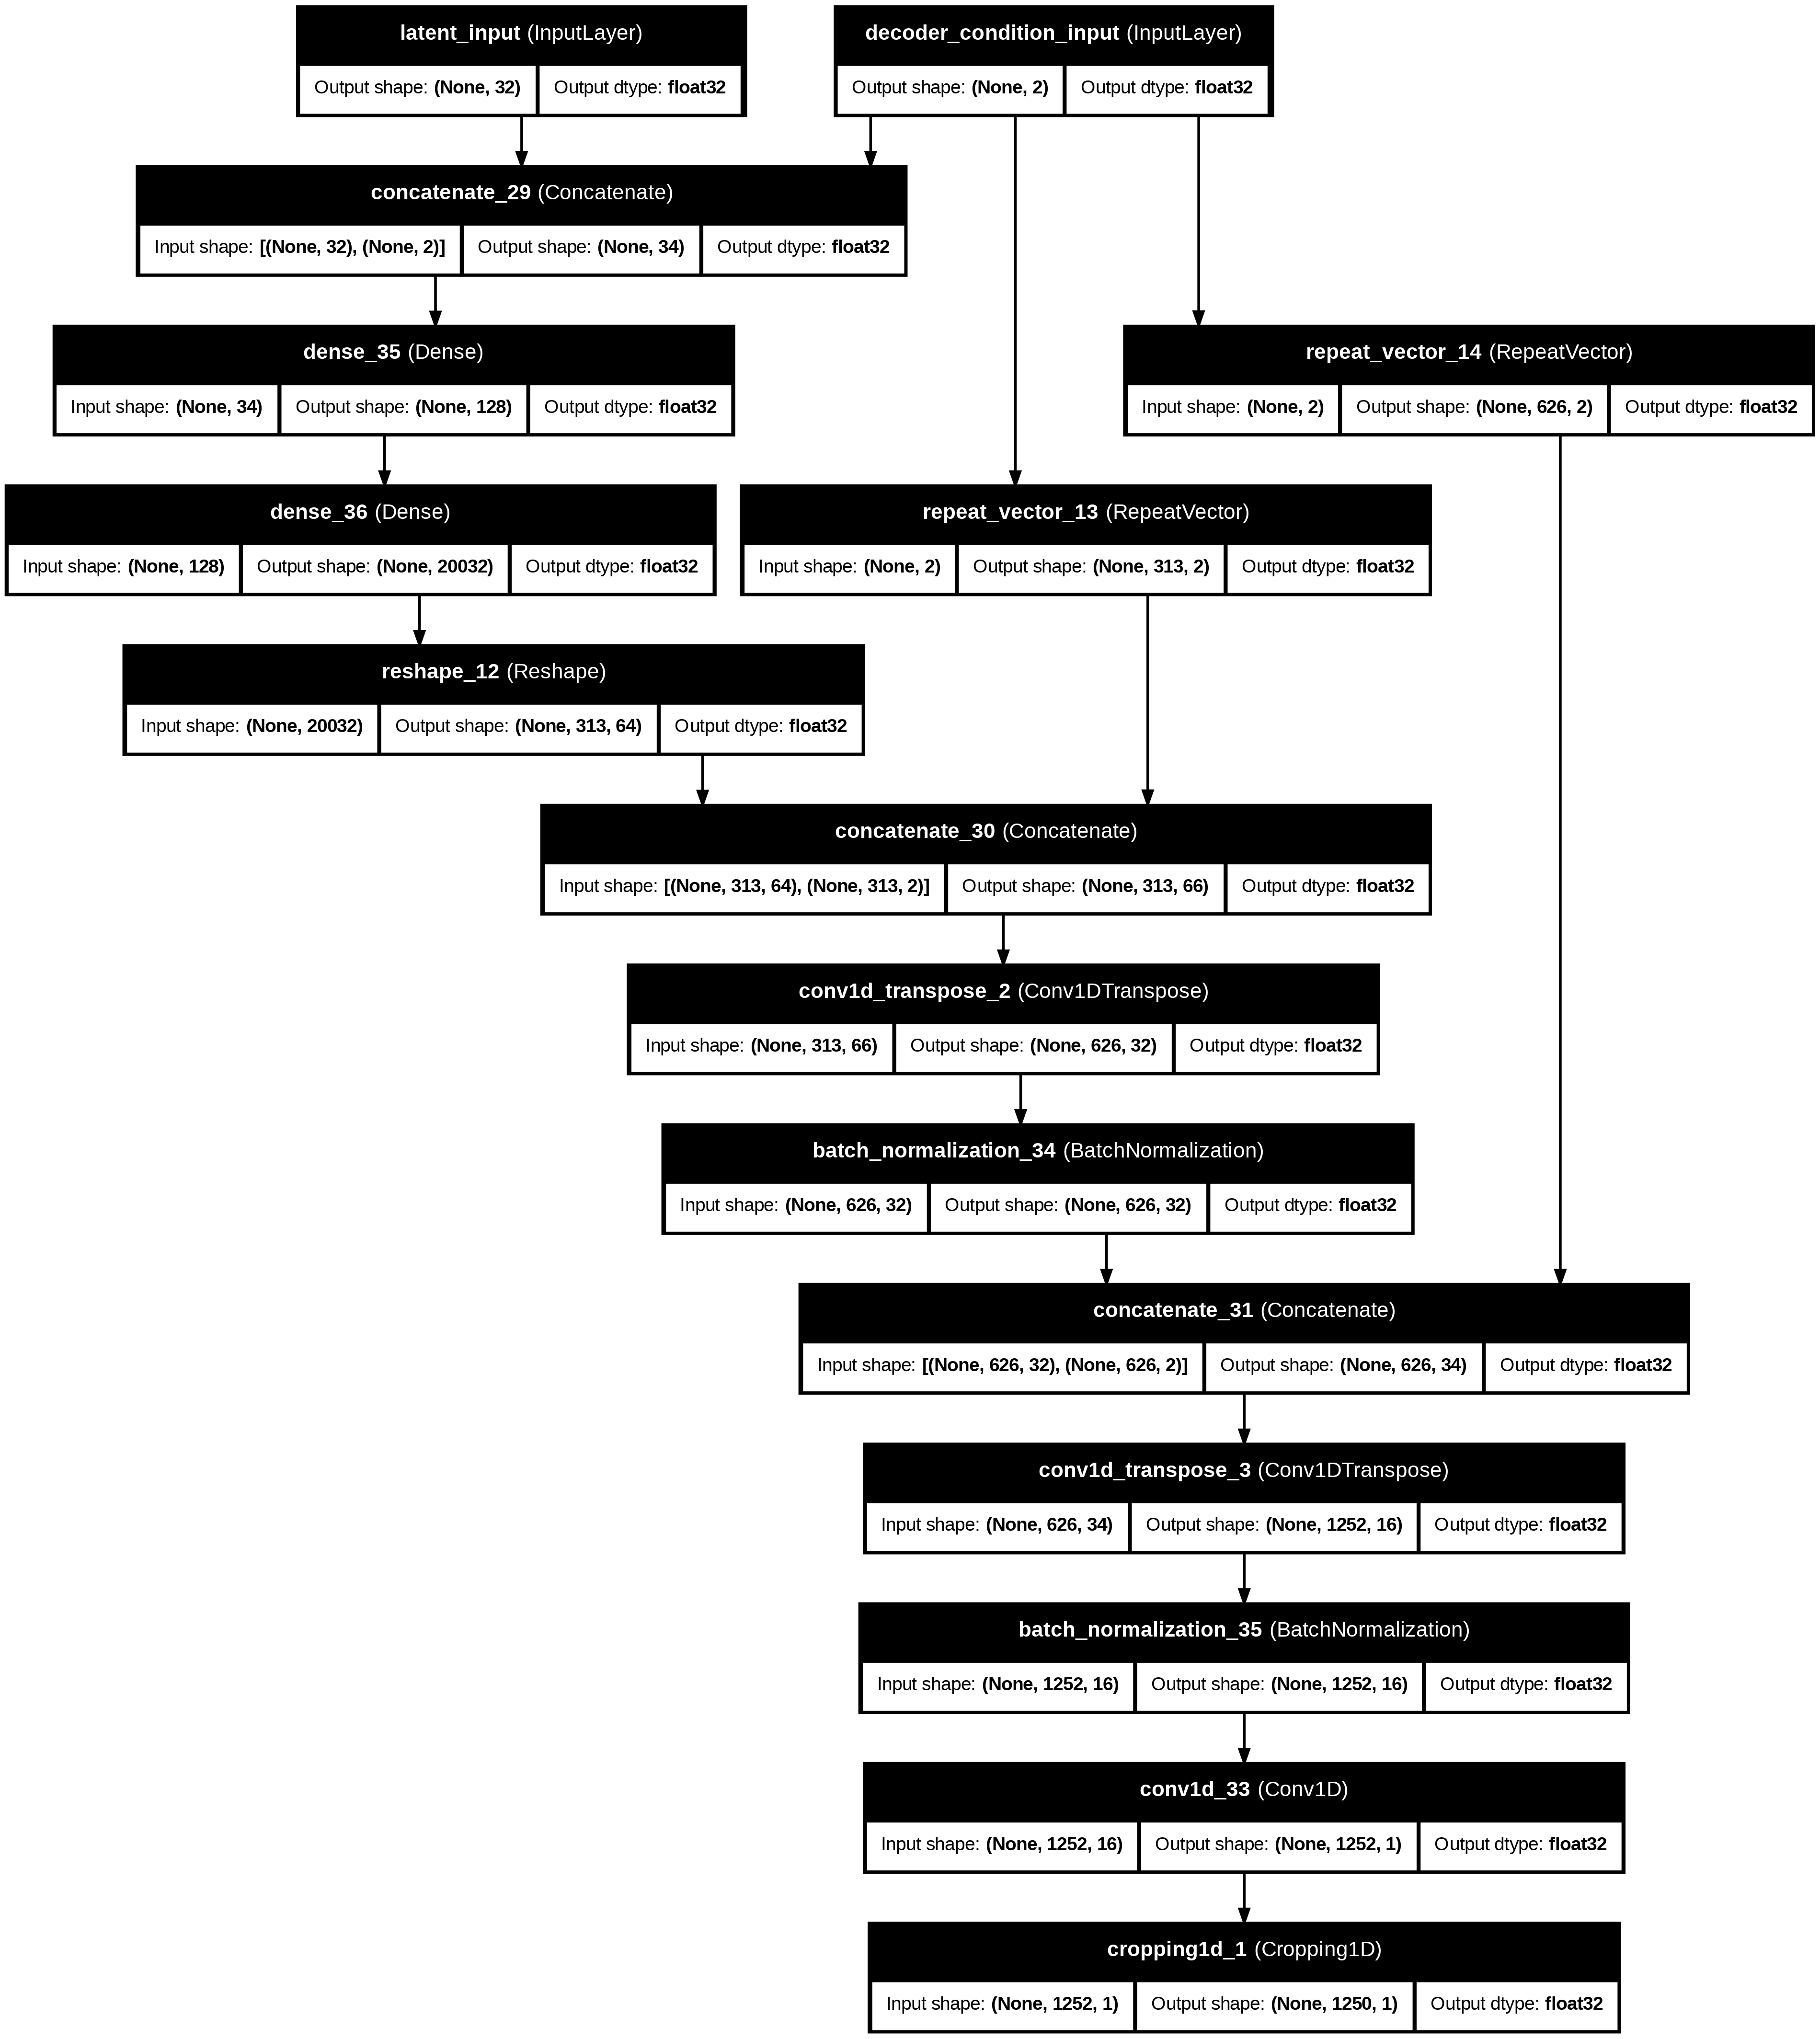

In [ ]:
# from IPython.display import Image
from tensorflow.keras.utils import plot_model

plot_model(decoder,show_shapes=True, show_dtype=True, show_layer_names=True)

In [ ]:
path_img = os.path.join(model_path, 'decoder_cnn_architecture.png')
try:
    plot_model(decoder, to_file=path_img,
               show_shapes=True, show_dtype=True, show_layer_names=True)
    print("Decoder model structure saved to 'models/decoder_cnn_architecture.png'")
except Exception as e:
    print(f"Could not save model structure: {e}")

Decoder model structure saved to 'models/decoder_cnn_architecture.png'


### 5.4. Tạo mô hình CNN-CVAE hoàn chỉnh và hàm mất mát

In [86]:
class CVAE_CNN_Combined(Model):
    """Conditional Variational Autoencoder kết hợp Encoder và Decoder."""
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE_CNN_Combined, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        # Trả về danh sách các metrics để Keras theo dõi và hiển thị
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """Một bước huấn luyện."""
        # Giải nén dữ liệu đầu vào (tín hiệu PPG và điều kiện HR/RR)
        if isinstance(data, tuple) and len(data) == 2:
            x, condition = data
            x = tf.reshape(x, (-1, 1250, 1))

        else: # Xử lý trường hợp dataset chỉ trả về một tensor (ví dụ khi không có y)
            x = data
            x = tf.reshape(x, (-1, 1250, 1))
            # Giả định bạn cần tạo condition giả nếu không được cung cấp
            # HOẶC lấy condition từ một nguồn khác nếu logic yêu cầu
            # Ví dụ đơn giản: tạo condition zeros (cần điều chỉnh nếu logic khác)
            # condition = tf.zeros((tf.shape(x)[0], condition_dim), dtype=tf.float32)
            # ---> Trong trường hợp này, dataset đã được tạo với (x, condition) nên luôn là tuple
            print("Cảnh báo: Dữ liệu đầu vào train_step không như mong đợi (cần tuple (x, condition)).")
             # Tạm dừng để tránh lỗi không mong muốn
            return {m.name: tf.constant(0.0) for m in self.metrics}


        # Sử dụng GradientTape để tự động tính đạo hàm
        with tf.GradientTape() as tape:
            # Đưa dữ liệu qua Encoder
            z_mean, z_log_var, z = self.encoder([x, condition], training=True)
            # z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
            # z_mean = tf.clip_by_value(z_mean, -10.0, 10.0)
            # Đưa z và condition qua Decoder để tái tạo tín hiệu
            reconstruction = self.decoder([z, condition], training=True)

            # Tính Reconstruction Loss (ví dụ: Mean Squared Error)
            # Tính tổng MSE trên chiều tín hiệu (axis=1), sau đó lấy trung bình theo batch
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(x - reconstruction), axis=[1, 2])
            )

            # Tính KL Divergence Loss
            # Công thức: -0.5 * sum(1 + z_log_var - square(z_mean) - exp(z_log_var))
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            # Lấy giá trị beta hiện tại cho KL Annealing
            current_beta = 1.0

            # Tính Total Loss = Reconstruction Loss + beta * KL Loss
            total_loss = reconstruction_loss + current_beta * kl_loss

        # Tính gradients của total_loss theo các tham số có thể huấn luyện
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Cập nhật trọng số của model bằng optimizer
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Cập nhật trạng thái của các metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Trả về dictionary chứa giá trị hiện tại của các metrics
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Một bước đánh giá (tương tự train_step nhưng không cập nhật trọng số)."""
        if isinstance(data, tuple) and len(data) == 2:
            x, condition = data
            x = tf.reshape(x, (-1, 1250, 1))
        else:
             print("Cảnh báo: Dữ liệu đầu vào test_step không như mong đợi.")
             return {m.name: tf.constant(0.0) for m in self.metrics}


        # Đưa dữ liệu qua model (training=False)
        z_mean, z_log_var, z = self.encoder([x, condition], training=False)
        # z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
        # z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
        # z_mean = tf.clip_by_value(z_mean, -10.0, 10.0)
        reconstruction = self.decoder([z, condition], training=False)

        # Tính các loss
        reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(x - reconstruction), axis=[1, 2])
            )
        kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

        # Lấy beta hiện tại (quan trọng để loss validation khớp với loss training)
        current_beta = 1.0
        total_loss = reconstruction_loss + current_beta * kl_loss

        # Cập nhật trạng thái các metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Trả về dictionary metrics
        return {m.name: m.result() for m in self.metrics}
    def call(self, inputs, training=False):
      x, condition = inputs
      x = tf.reshape(x, (-1, 1250, 1))
      z_mean, z_log_var, z = self.encoder([x, condition], training=training)
      reconstruction = self.decoder([z, condition], training=training)
      return reconstruction

In [ ]:
cvae = CVAE_CNN_Combined(encoder, decoder)
cvae.compile(optimizer=Adam(learning_rate=0.0001))

print("CNN-CVAE model compiled successfully with VAE loss function.")

CNN-CVAE model compiled successfully with VAE loss function.


### 5.5. Huấn luyện mô hình CNN-CVAE

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_total_loss',
    patience=50,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_path, 'cvae_cnn_checkpoint.keras'),
    save_best_only=True,
    monitor='val_total_loss',
    verbose=1
)

In [ ]:
csv_logger = keras.callbacks.CSVLogger(os.path.join(model_path, 'cvae_cnn_training_log.csv'))

In [90]:
try:
    print(f"Đang tải dữ liệu huấn luyện từ: {processed_data_path}")
    X_train = np.load(os.path.join(processed_data_path, 'X_train.npy'))
    # LƯU Ý QUAN TRỌNG: Load condition_train_raw.npy chứa giá trị HR/RR GỐC
    condition_train = np.load(os.path.join(processed_data_path, 'condition_train_raw.npy'))

    X_test = np.load(os.path.join(processed_data_path, 'X_test.npy'))
    # Load condition_test_raw.npy chứa giá trị HR/RR GỐC cho tập validation
    condition_test = np.load(os.path.join(processed_data_path, 'condition_test_raw.npy'))

    print("Tải dữ liệu huấn luyện và kiểm thử thành công.")
    print(f" - X_train shape: {X_train.shape}, condition_train shape: {condition_train.shape}")
    print(f" - X_test shape: {X_test.shape}, condition_test shape: {condition_test.shape}")

    # Kiểm tra số mẫu khớp nhau
    assert X_train.shape[0] == condition_train.shape[0], "Số mẫu X_train và condition_train không khớp!"
    assert X_test.shape[0] == condition_test.shape[0], "Số mẫu X_test và condition_test không khớp!"


except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file dữ liệu .npy trong {processed_data_path}.")
    print("Hãy đảm bảo bạn đã chạy thành công ô Tiền xử lý trước.")
    # Dừng thực thi ở đây nếu không có dữ liệu
    raise
except Exception as e:
    print(f"Lỗi khi tải dữ liệu .npy: {e}")
    raise


Đang tải dữ liệu huấn luyện từ: drive/MyDrive/KQGK/processed
Tải dữ liệu huấn luyện và kiểm thử thành công.
 - X_train shape: (2275, 1250), condition_train shape: (2275, 2)
 - X_test shape: (569, 1250), condition_test shape: (569, 2)


In [91]:
# Tạo dataset cho training
buffer_size = X_train.shape[0]
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, condition_train))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
# Prefetch để tối ưu pipeline dữ liệu
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(f" - Train dataset: Batch size={batch_size}, Shuffle buffer={buffer_size}")

# Tạo dataset cho validation/testing
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, condition_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
print(f" - Test dataset: Batch size={batch_size}")

 - Train dataset: Batch size=64, Shuffle buffer=2275
 - Test dataset: Batch size=64


In [ ]:
epochs = 1000
cnn_history = cvae.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset, # Dùng test_dataset làm validation data
        callbacks=[early_stopping, checkpoint, csv_logger],
        verbose=1
    )

if early_stopping.stopped_epoch > 0:
      print(f"Early stopping đã dừng huấn luyện tại epoch: {early_stopping.stopped_epoch + 1}")
      print(f"Trọng số tốt nhất từ epoch ~{early_stopping.stopped_epoch + 1 - early_stopping.patience} đã được khôi phục.")
else:
      # Nếu không dừng sớm, epoch tốt nhất là epoch cuối cùng lưu bởi ModelCheckpoint
      print(f"Huấn luyện hoàn thành {epochs} epochs hoặc ModelCheckpoint đã lưu trọng số tốt nhất.")

Epoch 1/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - kl_loss: 47.8215 - reconstruction_loss: 696.8513 - total_loss: 744.6729
Epoch 1: val_total_loss improved from inf to 414.00409, saving model to drive/MyDrive/KQGK/models/cvae_cnn_checkpoint.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - kl_loss: 47.7639 - reconstruction_loss: 693.4670 - total_loss: 741.2309 - val_kl_loss: 0.2805 - val_reconstruction_loss: 413.7236 - val_total_loss: 414.0041
Epoch 2/1000
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 41.6730 - reconstruction_loss: 343.5655 - total_loss: 385.2386
Epoch 2: val_total_loss did not improve from 414.00409
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 41.6826 - reconstruction_loss: 338.9863 - total_loss: 380.6690 - val_kl_loss: 1.3242 - val_reconstruction_loss: 440.3561 - val_total_loss: 441.6804
Epoch 3/1000
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 42.8635 - reconstruction_loss: 222.9920 - total_loss: 265.8555
Epoch 3: val_total_loss did not improve from 414.00409
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 42.8650 - reconstruction_loss: 222.0103 - total_loss: 264.8754 - val_kl_loss: 3.0849 - val_reconstruction_loss: 461.7631 - val_total_loss: 464.8480
Epoch 4/1000
36/36 ━━━━━━━━━━━━━━━━━━

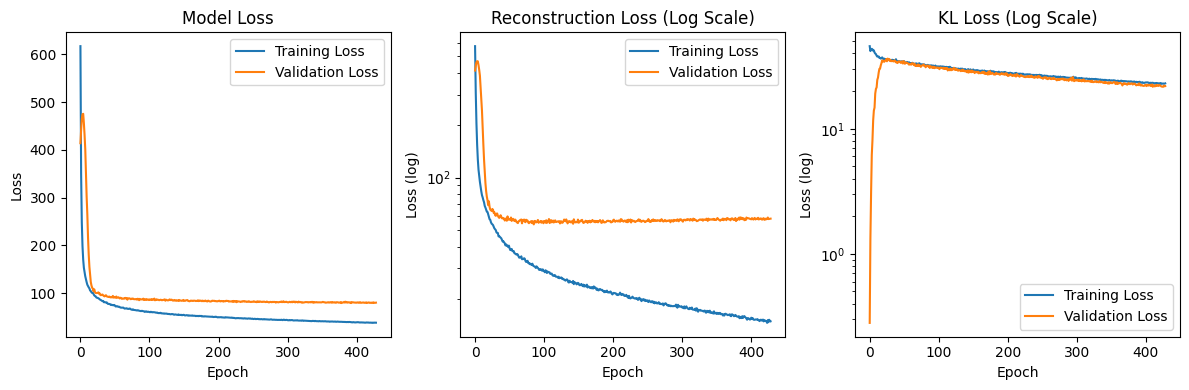

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(cnn_history.history['total_loss'], label='Training Loss')
plt.plot(cnn_history.history['val_total_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(cnn_history.history['reconstruction_loss'], label='Training Loss')
plt.plot(cnn_history.history['val_reconstruction_loss'], label='Validation Loss')
plt.title('Reconstruction Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(cnn_history.history['kl_loss'], label='Training Loss')
plt.plot(cnn_history.history['val_kl_loss'], label='Validation Loss')
plt.title('KL Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
path_his = os.path.join(model_path, 'cnn_cvae_training_history.png')
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(cnn_history.history['total_loss'], label='Training Loss')
plt.plot(cnn_history.history['val_total_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(cnn_history.history['reconstruction_loss'], label='Training Loss')
plt.plot(cnn_history.history['val_reconstruction_loss'], label='Validation Loss')
plt.title('Reconstruction Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(cnn_history.history['kl_loss'], label='Training Loss')
plt.plot(cnn_history.history['val_kl_loss'], label='Validation Loss')
plt.title('KL Loss (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(path_his)
plt.close()

In [ ]:
print("CNN-CVAE models saved successfully.")
cvae.save(os.path.join(model_path, 'cnn_cvae_model1.keras'))
encoder.save(os.path.join(model_path, 'cnn_cvae_encoder.keras'))
decoder.save(os.path.join(model_path, 'cnn_cvae_decoder.keras'))
print("Models saved successfully.")

CNN-CVAE models saved successfully.
Models saved successfully.


### 5.6. So sánh hiệu suất giữa hai mô hình

In [87]:
import tensorflow as tf
# Load model
encoder =build_encoder(1250,2,32)
decoder = build_decoder(32,2,1250)
cvae = CVAE_Combined(encoder, decoder)

dummy_x = tf.random.normal((64, 1250))
dummy_condition = tf.random.normal((64, 2))
_ = cvae((dummy_x, dummy_condition))
cvae.load_weights(os.path.join(model_path, 'cvae_checkpoint.keras'))
cvae.compile(optimizer='adam')

In [88]:
encoder_cnn =build_encoder_cnn(1250,2,32)
decoder_cnn = build_decoder_cnn(latent_dim=32, condition_dim=2, output_dim=1250)
cvae_cnn = CVAE_CNN_Combined(encoder_cnn, decoder_cnn)

dummy_x = tf.random.normal((64, 1250))
dummy_condition = tf.random.normal((64, 2))
_ = cvae_cnn((dummy_x, dummy_condition))
cvae_cnn.load_weights(os.path.join(model_path, 'cvae_cnn_checkpoint.keras'))
cvae_cnn.compile(optimizer='adam')

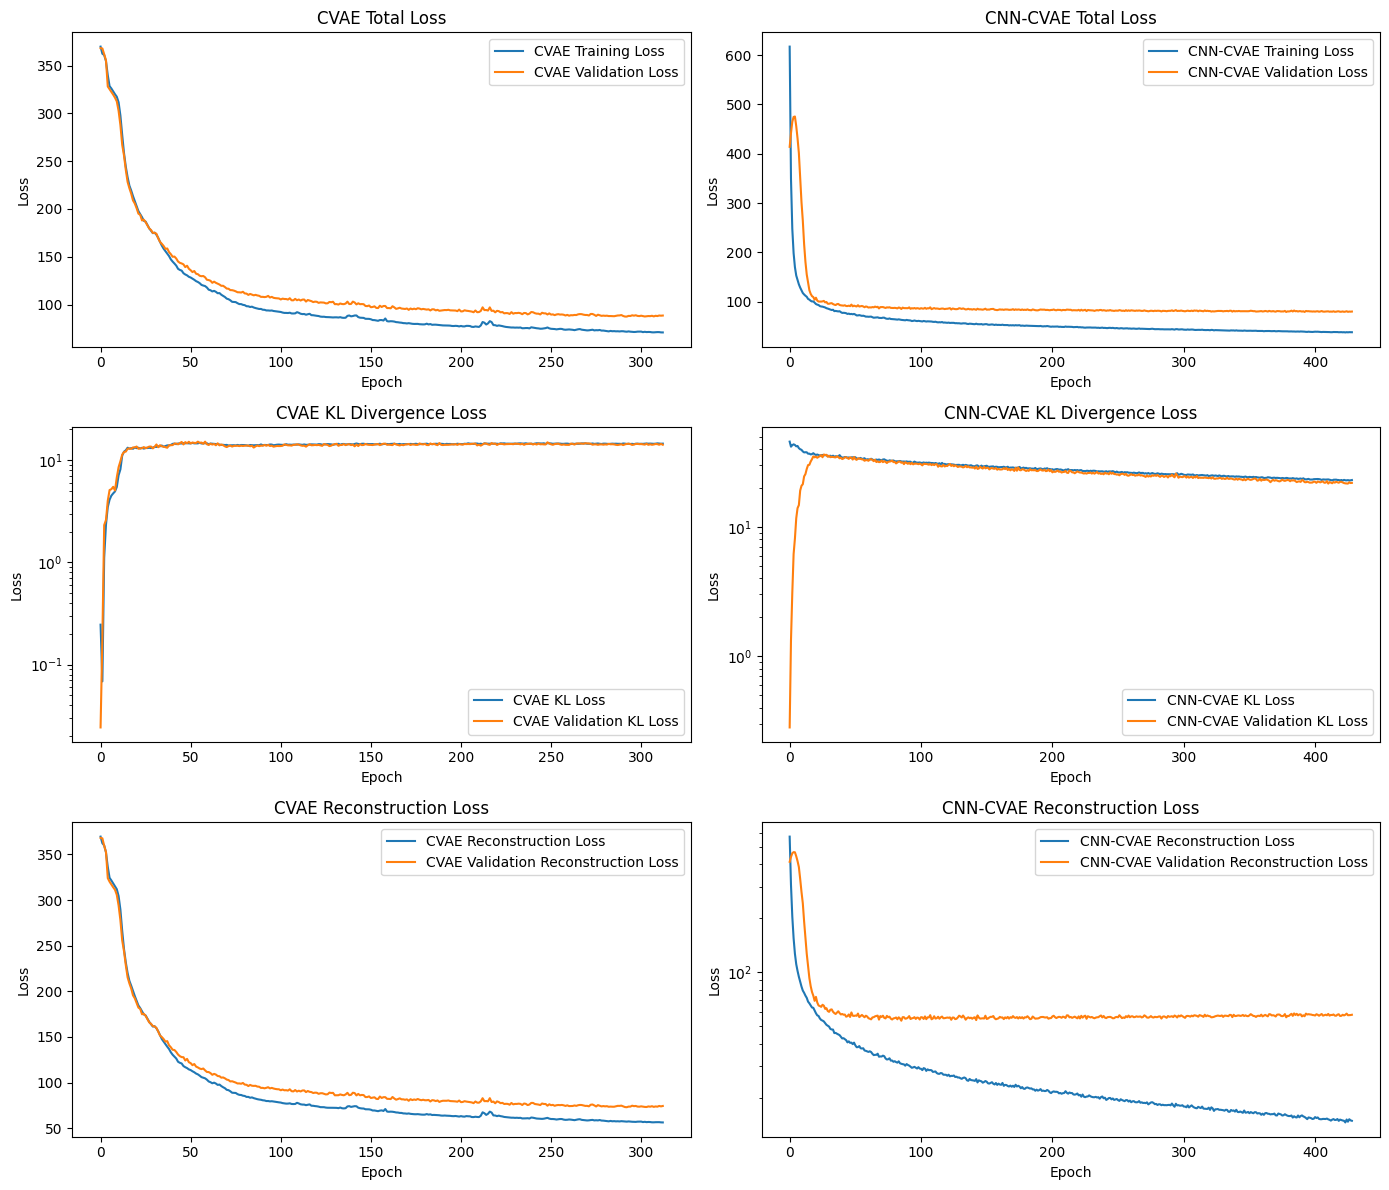

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))  # Kích thước lớn hơn để chứa hai cột

# Cột 1: CVAE
plt.subplot(3, 2, 1)  # 3 hàng, 2 cột, ô số 1
plt.plot(history.history['total_loss'], label='CVAE Training Loss')
plt.plot(history.history['val_total_loss'], label='CVAE Validation Loss')
plt.title('CVAE Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 5)  # 3 hàng, 2 cột, ô số 2
plt.plot(history.history['reconstruction_loss'], label='CVAE Reconstruction Loss')
plt.plot(history.history['val_reconstruction_loss'], label='CVAE Validation Reconstruction Loss')
plt.title('CVAE Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.yscale('log')
plt.legend()

plt.subplot(3, 2, 3)  # 3 hàng, 2 cột, ô số 3
plt.plot(history.history['kl_loss'], label='CVAE KL Loss')
plt.plot(history.history['val_kl_loss'], label='CVAE Validation KL Loss')
plt.title('CVAE KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Cột 2: CNN-CVAE
plt.subplot(3, 2, 2)  # 3 hàng, 2 cột, ô số 4
plt.plot(cnn_history.history['total_loss'], label='CNN-CVAE Training Loss')
plt.plot(cnn_history.history['val_total_loss'], label='CNN-CVAE Validation Loss')
plt.title('CNN-CVAE Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 6)  # 3 hàng, 2 cột, ô số 5
plt.plot(cnn_history.history['reconstruction_loss'], label='CNN-CVAE Reconstruction Loss')
plt.plot(cnn_history.history['val_reconstruction_loss'], label='CNN-CVAE Validation Reconstruction Loss')
plt.title('CNN-CVAE Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(3, 2, 4)  # 3 hàng, 2 cột, ô số 6
plt.plot(cnn_history.history['kl_loss'], label='CNN-CVAE KL Loss')
plt.plot(cnn_history.history['val_kl_loss'], label='CNN-CVAE Validation KL Loss')
plt.title('CNN-CVAE KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))  # Kích thước lớn hơn để chứa hai cột

# Cột 1: CVAE
plt.subplot(3, 2, 1)  # 3 hàng, 2 cột, ô số 1
plt.plot(history.history['total_loss'], label='CVAE Training Loss')
plt.plot(history.history['val_total_loss'], label='CVAE Validation Loss')
plt.title('CVAE Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 5)  # 3 hàng, 2 cột, ô số 2
plt.plot(history.history['reconstruction_loss'], label='CVAE Reconstruction Loss')
plt.plot(history.history['val_reconstruction_loss'], label='CVAE Validation Reconstruction Loss')
plt.title('CVAE Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(3, 2, 3)  # 3 hàng, 2 cột, ô số 3
plt.plot(history.history['kl_loss'], label='CVAE KL Loss')
plt.plot(history.history['val_kl_loss'], label='CVAE Validation KL Loss')
plt.title('CVAE KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Cột 2: CNN-CVAE
plt.subplot(3, 2, 2)  # 3 hàng, 2 cột, ô số 4
plt.plot(cnn_history.history['total_loss'], label='CNN-CVAE Training Loss')
plt.plot(cnn_history.history['val_total_loss'], label='CNN-CVAE Validation Loss')
plt.title('CNN-CVAE Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 6)  # 3 hàng, 2 cột, ô số 5
plt.plot(cnn_history.history['reconstruction_loss'], label='CNN-CVAE Reconstruction Loss')
plt.plot(cnn_history.history['val_reconstruction_loss'], label='CNN-CVAE Validation Reconstruction Loss')
plt.title('CNN-CVAE Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(3, 2, 4)  # 3 hàng, 2 cột, ô số 6
plt.plot(cnn_history.history['kl_loss'], label='CNN-CVAE KL Loss')
plt.plot(cnn_history.history['val_kl_loss'], label='CNN-CVAE Validation KL Loss')
plt.title('CNN-CVAE KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(model_path, 'loss_comparison.png'))
plt.close()


In [92]:
# Đánh giá trên tập test và hiển thị kết quả
cvae_test_loss = cvae.evaluate(test_dataset)
cnn_cvae_test_loss = cvae_cnn.evaluate(test_dataset)

print(f"CVAE Test Loss: {cvae_test_loss[0]:.4f}")
print(f"CNN-CVAE Test Loss: {cnn_cvae_test_loss[0]:.4f}")
print(f"Improvement: {(1 - cnn_cvae_test_loss[0]/cvae_test_loss[0]) * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 14.4186 - reconstruction_loss: 72.1000 - total_loss: 86.5186  
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - kl_loss: 22.8320 - reconstruction_loss: 57.3196 - total_loss: 80.1515
CVAE Test Loss: 87.7978
CNN-CVAE Test Loss: 80.7580
Improvement: 8.02%


In [93]:
#Cell 4: So sánh tín hiệu PPG tạo ra từ hai mô hình
def generate_cnn_ppg(hr, rr, num_samples=1):
    """
    Tạo tín hiệu PPG mới từ mô hình CNN-CVAE.
    """
    # Chuẩn hóa điều kiện
    hr_norm = (hr - hr_mean) / hr_std
    rr_norm = (rr - rr_mean) / rr_std
    conditions = np.array([[hr_norm, rr_norm]] * num_samples)

    # Tạo vector ngẫu nhiên trong không gian tiềm ẩn
    z = np.random.normal(size=(num_samples, 32))

    # Tạo tín hiệu PPG mới
    generated_ppg_norm = decoder.predict([z, conditions])
    original_scale_ppg = normalize_to_range(generated_ppg_norm,-1,1)

    return generated_ppg_norm,original_scale_ppg

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


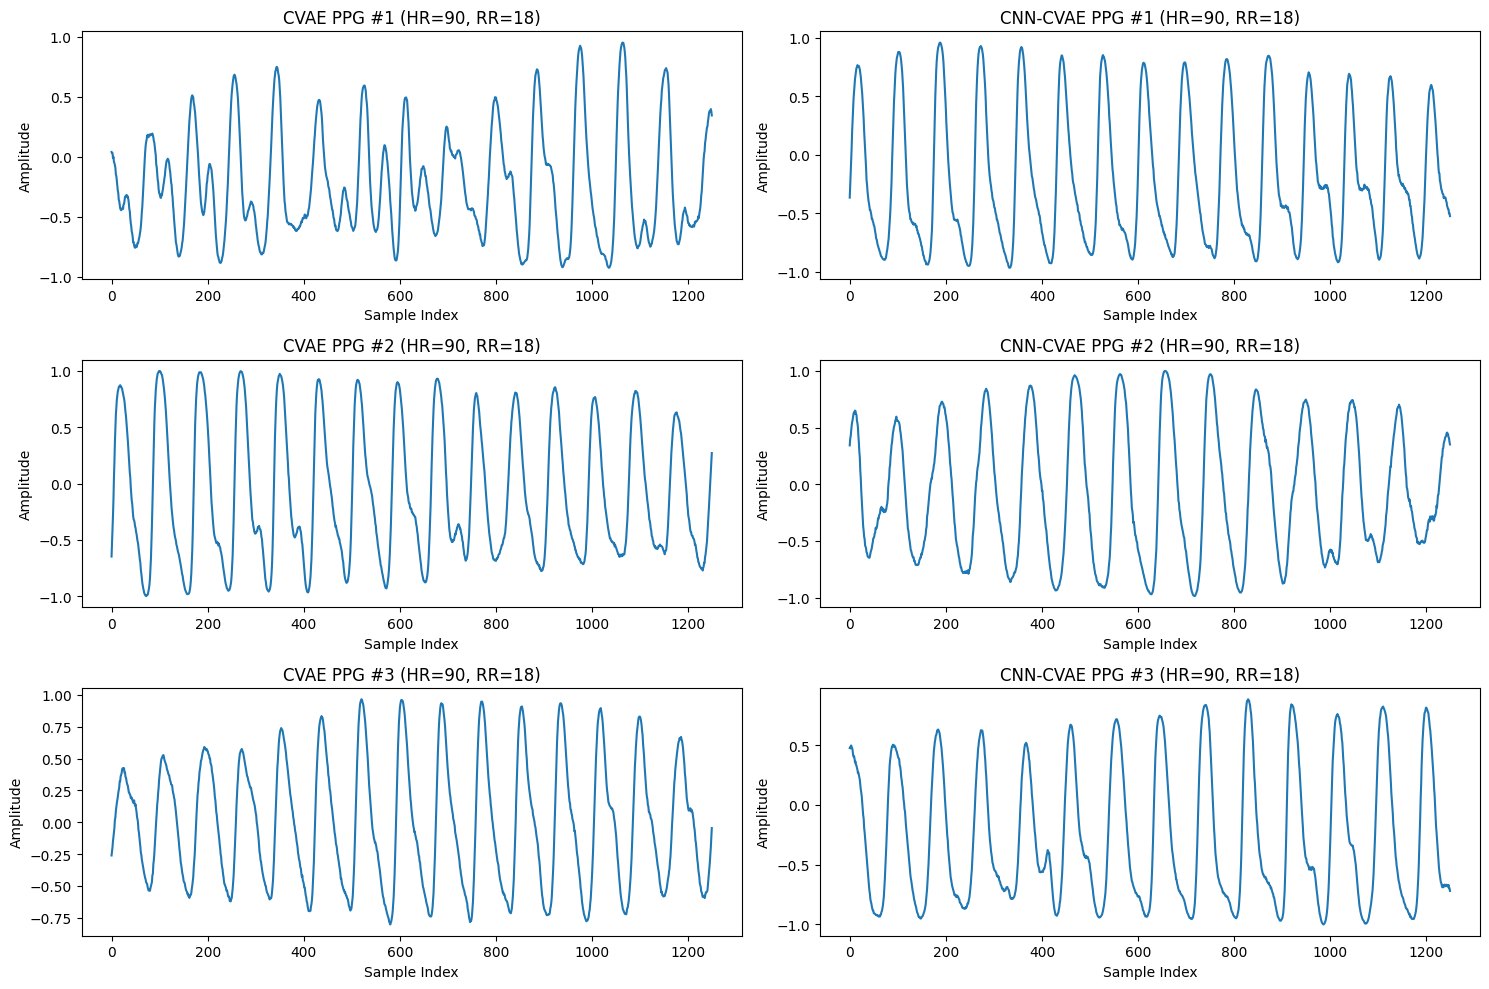

In [96]:
# Tạo tín hiệu từ cả hai mô hình với cùng điều kiện
hr_test = 90
rr_test = 18

_,cvae_ppg = generate_ppg(hr_test, rr_test, num_samples=3)
_, cnn_cvae_ppg = generate_cnn_ppg(hr_test, rr_test, num_samples=3)

# Vẽ và so sánh tín hiệu
plt.figure(figsize=(15, 10))

for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(cvae_ppg[i])
    plt.title(f'CVAE PPG #{i+1} (HR={hr_test}, RR={rr_test})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

    plt.subplot(3, 2, i*2+2)
    plt.plot(cnn_cvae_ppg[i])
    plt.title(f'CNN-CVAE PPG #{i+1} (HR={hr_test}, RR={rr_test})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [95]:
plt.figure(figsize=(15, 10))

for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(cvae_ppg[i])
    plt.title(f'CVAE PPG #{i+1} (HR={hr_test}, RR={rr_test})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

    plt.subplot(3, 2, i*2+2)
    plt.plot(cnn_cvae_ppg[i])
    plt.title(f'CNN-CVAE PPG #{i+1} (HR={hr_test}, RR={rr_test})')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.savefig(os.path.join(model_path, 'model_generation_comparison.png'), dpi=300, bbox_inches='tight')
plt.close()
print("Model generation comparison plot saved to 'models/model_generation_comparison.png'")

Model generation comparison plot saved to 'models/model_generation_comparison.png'


## 6. ĐÁNH GIÁ MÔ HÌNH

### 6.1. Tải dữ liệu Capnobase

In [100]:
X_test = np.load(os.path.join(processed_data_path, 'X_capno.npy'))
# Load condition_test_raw.npy chứa giá trị HR/RR GỐC cho tập validation
condition_test = np.load(os.path.join(processed_data_path, 'condition_capno.npy'))
# Tạo dataset cho training
buffer_size = X_test.shape[0]
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_test, condition_test))
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size)
# Prefetch để tối ưu pipeline dữ liệu
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(f" - Train dataset: Batch size={batch_size}, Shuffle buffer={buffer_size}")

# Tạo dataset cho validation/testing
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, condition_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
print(f" - Test dataset: Batch size={batch_size}")

 - Train dataset: Batch size=64, Shuffle buffer=360
 - Test dataset: Batch size=64


### 6.2. Đánh giá định lượng

In [101]:
def extract_hr_from_ppg(ppg_signal, fs=250):
    """
    Trích xuất nhịp tim từ tín hiệu PPG.

    Parameters:
    -----------
    ppg_signal : ndarray
        Tín hiệu PPG
    fs : int
        Tần số lấy mẫu (Hz)

    Returns:
    --------
    float
        Nhịp tim (bpm)
    """
    from scipy.signal import find_peaks

    # Tìm các đỉnh trong tín hiệu PPG
    peaks, _ = find_peaks(ppg_signal, distance=fs*0.5)  # Giả sử HR tối thiểu là 30 bpm

    if len(peaks) < 2:
        return 0

    # Tính toán khoảng cách trung bình giữa các đỉnh (tính theo mẫu)
    peak_intervals = np.diff(peaks)
    avg_interval = np.mean(peak_intervals)

    # Chuyển đổi sang bpm
    hr = 60 * fs / avg_interval

    return hr

In [102]:
def extract_br_from_ppg(ppg_signal, fs=250):
    """
    Trích xuất nhịp thở từ tín hiệu PPG dựa trên biến thiên tần số thấp.

    Parameters:
    -----------
    ppg_signal : ndarray
        Tín hiệu PPG
    fs : int
        Tần số lấy mẫu (Hz)

    Returns:
    --------
    float
        Nhịp thở (bpm)
    """
    from scipy import signal
    from scipy.fft import fft, fftfreq

    # Lọc thông thấp để lấy biến thiên tần số thấp (respiration)
    b, a = signal.butter(3, [0.1, 0.5], 'bandpass', fs=fs)
    filtered_signal = signal.filtfilt(b, a, ppg_signal)

    # Thực hiện FFT
    fft_result = fft(filtered_signal)
    freq = fftfreq(len(filtered_signal), 1/fs)

    # Chỉ quan tâm đến nửa đầu của FFT và tần số dương
    pos_freq_idx = np.where((freq > 0.1) & (freq < 0.5))
    fft_magnitude = np.abs(fft_result[pos_freq_idx])
    pos_freq = freq[pos_freq_idx]

    if len(fft_magnitude) == 0:
        return 0

    # Tìm tần số với biên độ lớn nhất trong dải 0.1-0.5 Hz (tương ứng với 6-30 breaths/min)
    max_idx = np.argmax(fft_magnitude)
    br_freq = pos_freq[max_idx]

    # Chuyển đổi sang bpm
    br = br_freq * 60

    return br

In [103]:
def evaluate_model(model_name, model, encoder, decoder,test_dataset, num_samples=20):
    """
    Đánh giá mô hình dựa trên MSE và độ chính xác HR, BR.
    """

    # Đánh giá MSE trên tập test
    test_loss = model.evaluate(test_dataset, verbose=0)
    print(f"{model_name} Test Loss: {test_loss[0]:.4f}")

    # Tạo tín hiệu PPG với các HR và BR từ tập test
    hr_br_errors = []

    batch = next(iter(test_dataset.take(1)))  # Lấy batch đầu tiên
    signal_batch, condition_batch = batch

    for i in range(min(num_samples, len(signal_batch))):
        # Lấy HR và BR thực tế (chuyển từ dạng chuẩn hóa về giá trị gốc)
        hr_actual = condition_batch[i][0] * hr_std + hr_mean
        br_actual = condition_batch[i][1] * rr_std + rr_mean

        # Tạo tín hiệu PPG
        if model_name == "CNN-CVAE":
            _,ppg = generate_cnn_ppg(hr_actual, br_actual, num_samples=1)
            ppg = ppg[0] if isinstance(ppg, np.ndarray) and ppg.ndim > 1 else ppg
        else:
            _,ppg = generate_ppg(hr_actual, br_actual, num_samples=1)
            ppg = ppg[0]

        # Trích xuất HR và BR từ tín hiệu PPG
        hr_extracted = extract_hr_from_ppg(ppg, fs=250)
        br_extracted = extract_br_from_ppg(ppg, fs=250)

        # Tính sai số
        hr_error = np.abs(hr_extracted - hr_actual)
        br_error = np.abs(br_extracted - br_actual)

        hr_br_errors.append((hr_error, br_error))

        print(f"Sample {i+1}: HR Actual={hr_actual:.1f}, Extracted={hr_extracted:.1f}, Error={hr_error:.1f}")
        print(f"Sample {i+1}: BR Actual={br_actual:.1f}, Extracted={br_extracted:.1f}, Error={br_error:.1f}")

    # Tính trung bình sai số
    hr_errors, br_errors = zip(*hr_br_errors)
    mean_hr_error = np.mean(hr_errors)
    mean_br_error = np.mean(br_errors)

    print(f"{model_name} Mean HR Error: {mean_hr_error:.2f} bpm")
    print(f"{model_name} Mean BR Error: {mean_br_error:.2f} bpm")

    return {
        "test_loss": test_loss,
        "mean_hr_error": mean_hr_error,
        "mean_br_error": mean_br_error,
        "hr_errors": hr_errors,
        "br_errors": br_errors
    }

In [131]:
cvae_eval = evaluate_model("CVAE", cvae, encoder, decoder, test_dataset, num_samples=10)

CVAE Test Loss: 119.0871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sample 1: HR Actual=86.9, Extracted=88.8, Error=1.9
Sample 1: BR Actual=14.1, Extracted=12.0, Error=2.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sample 2: HR Actual=84.9, Extracted=77.3, Error=7.6
Sample 2: BR Actual=14.3, Extracted=12.0, Error=2.3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sample 3: HR Actual=83.2, Extracted=74.5, Error=8.7
Sample 3: BR Actual=15.8, Extracted=12.0, Error=3.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sample 4: HR Actual=83.4, Extracted=93.4, Error=10.0
Sample 4: BR Actual=16.1, Extracted=12.0, Error=4.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sample 5: HR Actual=84.2, Extracted=74.3, Error=9.9
Sample 5: BR Actual=14.7, Extracted=12.0, Error=2.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sample 6: HR Actual=81.1, Extracted=88.9, Error=7.8
Sample 6: BR Actual=15.4, Extracted=24.0, Error=8.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sample 7: HR Actual=81.2, Extracted=79.0, Error=2.2
Sample 7: BR Actual=15.6, Extrac

In [114]:
cnn_cvae_eval = evaluate_model("CNN-CVAE", cvae_cnn, encoder_cnn, decoder_cnn, test_dataset, num_samples=10)

CNN-CVAE Test Loss: 135.1888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sample 1: HR Actual=86.9, Extracted=88.5, Error=1.6
Sample 1: BR Actual=14.1, Extracted=12.0, Error=2.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sample 2: HR Actual=84.9, Extracted=91.4, Error=6.5
Sample 2: BR Actual=14.3, Extracted=12.0, Error=2.3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sample 3: HR Actual=83.2, Extracted=83.4, Error=0.2
Sample 3: BR Actual=15.8, Extracted=12.0, Error=3.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Sample 4: HR Actual=83.4, Extracted=94.4, Error=11.0
Sample 4: BR Actual=16.1, Extracted=12.0, Error=4.1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sample 5: HR Actual=84.2, Extracted=81.8, Error=2.4
Sample 5: BR Actual=14.7, Extracted=12.0, Error=2.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Sample 6: HR Actual=81.1, Extracted=86.1, Error=4.9
Sample 6: BR Actual=15.4, Extracted=12.0, Error=3.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sample 7: HR Actual=81.2, Extracted=85.2, Error=4.0
Sample 7: BR Actual=15.6, Ex

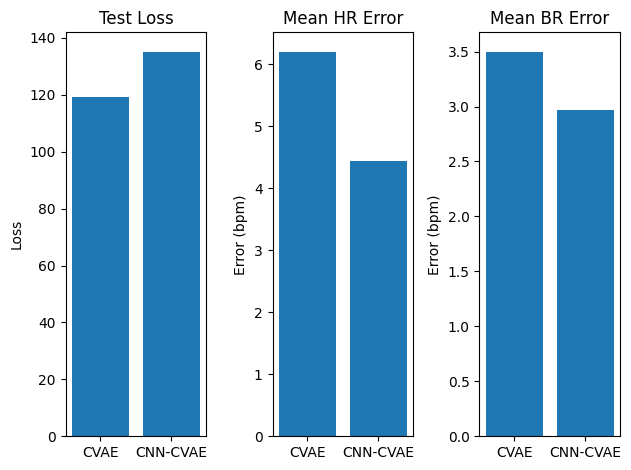

In [132]:
# So sánh Test Loss
plt.subplot(1, 3, 1)
plt.bar(['CVAE', 'CNN-CVAE'], [cvae_eval['test_loss'][0], cnn_cvae_eval['test_loss'][0]])
plt.title('Test Loss')
plt.ylabel('Loss')

# So sánh HR Error
plt.subplot(1, 3, 2)
plt.bar(['CVAE', 'CNN-CVAE'], [cvae_eval['mean_hr_error'], cnn_cvae_eval['mean_hr_error']])
plt.title('Mean HR Error')
plt.ylabel('Error (bpm)')

# # So sánh BR Error
plt.subplot(1, 3, 3)
plt.bar(['CVAE', 'CNN-CVAE'], [cvae_eval['mean_br_error'], cnn_cvae_eval['mean_br_error']])
plt.title('Mean BR Error')
plt.ylabel('Error (bpm)')

plt.tight_layout()
plt.show()

In [133]:
# So sánh Test Loss
plt.subplot(1, 3, 1)
plt.bar(['CVAE', 'CNN-CVAE'], [cvae_eval['test_loss'][0], cnn_cvae_eval['test_loss'][0]])
plt.title('Test Loss')
plt.ylabel('Loss')

# So sánh HR Error
plt.subplot(1, 3, 2)
plt.bar(['CVAE', 'CNN-CVAE'], [cvae_eval['mean_hr_error'], cnn_cvae_eval['mean_hr_error']])
plt.title('Mean HR Error')
plt.ylabel('Error (bpm)')

# # So sánh BR Error
plt.subplot(1, 3, 3)
plt.bar(['CVAE', 'CNN-CVAE'], [cvae_eval['mean_br_error'], cnn_cvae_eval['mean_br_error']])
plt.title('Mean BR Error')
plt.ylabel('Error (bpm)')

plt.tight_layout()
plt.savefig(os.path.join(model_path, 'mean_error_comparison.png'))
plt.close()

### 6.2. Đánh giá định tính

In [134]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import numpy as np


def plot_frequency_spectrum(signal, fs=250, title="Frequency Spectrum"):
    """
    Vẽ phổ tần số của tín hiệu.

    Parameters:
    -----------
    signal : ndarray
        Tín hiệu cần phân tích
    fs : int
        Tần số lấy mẫu (Hz)
    title : str
        Tiêu đề biểu đồ
    """
    # Thực hiện FFT
    fft_result = fft(np.array(signal))
    freq = fftfreq(len(signal), 1/fs)

    # Chỉ quan tâm đến nửa đầu và tần số dương
    n = len(signal)
    fft_magnitude = np.abs(fft_result[:n//2])
    pos_freq = freq[:n//2]

    plt.plot(pos_freq, fft_magnitude)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim([0, 5])  # Giới hạn tần số hiển thị đến 5 Hz

In [135]:
sample_idx = 3
batch = next(iter(test_dataset.take(1)))  # Lấy batch đầu tiên
signal_batch, condition_batch = batch
real_ppg = signal_batch[sample_idx]

hr_actual = condition_batch[sample_idx][0] * hr_std + hr_mean
br_actual = condition_batch[sample_idx][1] * rr_std + rr_mean

_,cvae_ppg = generate_ppg(hr_actual, br_actual, num_samples=1)
_,cnn_ppg = generate_cnn_ppg(hr_actual, br_actual, num_samples=1)
cvae_ppg_signal = cvae_ppg[0]
cnn_ppg_signal = cnn_ppg[0] if isinstance(cnn_ppg, np.ndarray) and cnn_ppg.ndim > 1 else cnn_ppg

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


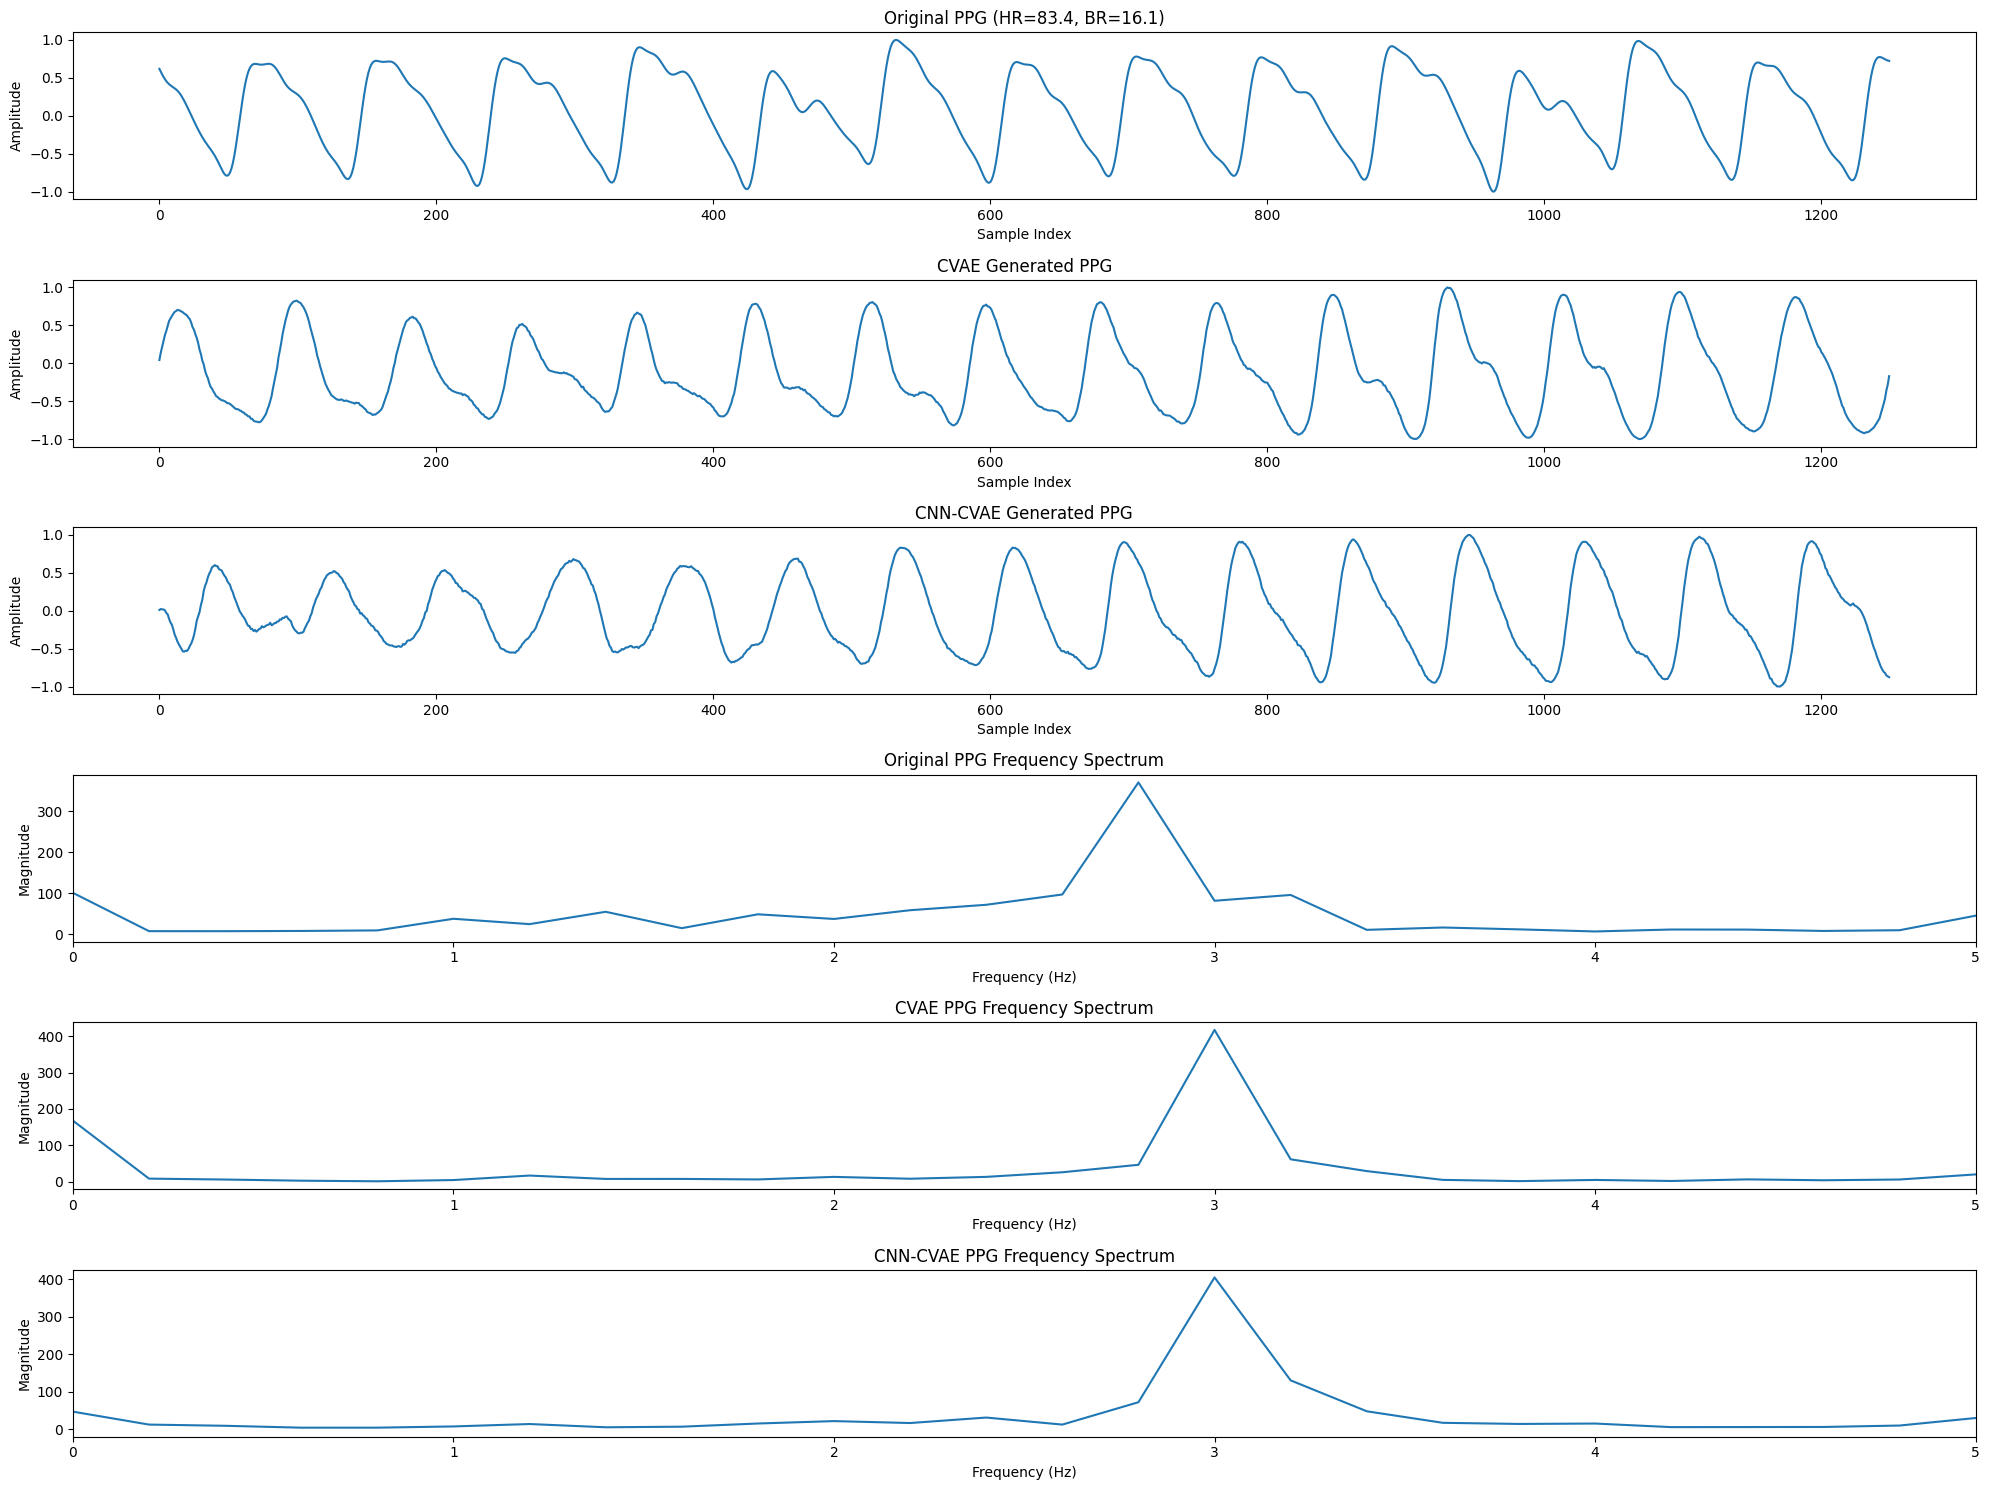

In [136]:
plt.figure(figsize=(20,15))
plt.subplot(6, 1, 1)
plt.plot(real_ppg)
plt.title(f'Original PPG (HR={hr_actual:.1f}, BR={br_actual:.1f})')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.subplot(6, 1, 2)
plt.plot(cvae_ppg_signal)
plt.title('CVAE Generated PPG')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.subplot(6, 1, 3)
plt.plot(cnn_ppg_signal)
plt.title('CNN-CVAE Generated PPG')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.subplot(6, 1, 4)
plot_frequency_spectrum(real_ppg, fs=250, title="Original PPG Frequency Spectrum")

plt.subplot(6, 1, 5)
plot_frequency_spectrum(cvae_ppg_signal, fs=250, title="CVAE PPG Frequency Spectrum")

plt.subplot(6, 1, 6)
plot_frequency_spectrum(cnn_ppg_signal, fs=250, title="CNN-CVAE PPG Frequency Spectrum")

plt.tight_layout()
plt.show()

In [137]:
plt.figure(figsize=(20,15))
plt.subplot(6, 1, 1)
plt.plot(real_ppg)
plt.title(f'Original PPG (HR={hr_actual:.1f}, BR={br_actual:.1f})')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.subplot(6, 1, 2)
plt.plot(cvae_ppg_signal)
plt.title('CVAE Generated PPG')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.subplot(6, 1, 3)
plt.plot(cnn_ppg_signal)
plt.title('CNN-CVAE Generated PPG')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

plt.subplot(6, 1, 4)
plot_frequency_spectrum(real_ppg, fs=250, title="Original PPG Frequency Spectrum")

plt.subplot(6, 1, 5)
plot_frequency_spectrum(cvae_ppg_signal, fs=250, title="CVAE PPG Frequency Spectrum")

plt.subplot(6, 1, 6)
plot_frequency_spectrum(cnn_ppg_signal, fs=250, title="CNN-CVAE PPG Frequency Spectrum")

plt.tight_layout()
plt.savefig(os.path.join(model_path, 'signal_frequency_analysis.png'))
plt.close()
print("CNN-CVAE consistency check saved to 'signal_frequency_analysis.png'")

CNN-CVAE consistency check saved to 'signal_frequency_analysis.png'


In [138]:
#: Kiểm tra tính nhất quán của các tín hiệu được tạo ra
def plot_consistency_check(hr, rr, model_type='CVAE', num_samples=5):
    """
    Tạo và vẽ nhiều mẫu tín hiệu PPG từ cùng một bộ thông số HR, BR.
    """
    plt.figure(figsize=(12, 10))

    for i in range(num_samples):
        if model_type == 'CVAE':
            _,ppg = generate_ppg(hr, rr, num_samples=1)
            ppg_signal = ppg[0]
        else:  # CNN-CVAE
            _,ppg = generate_cnn_ppg(hr, rr, num_samples=1)
            ppg_signal = ppg[0] if isinstance(ppg, np.ndarray) and ppg.ndim > 1 else ppg

        plt.subplot(num_samples, 1, i+1)
        plt.plot(ppg_signal)
        plt.title(f'{model_type} Sample #{i+1} (HR={hr}, RR={rr})')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


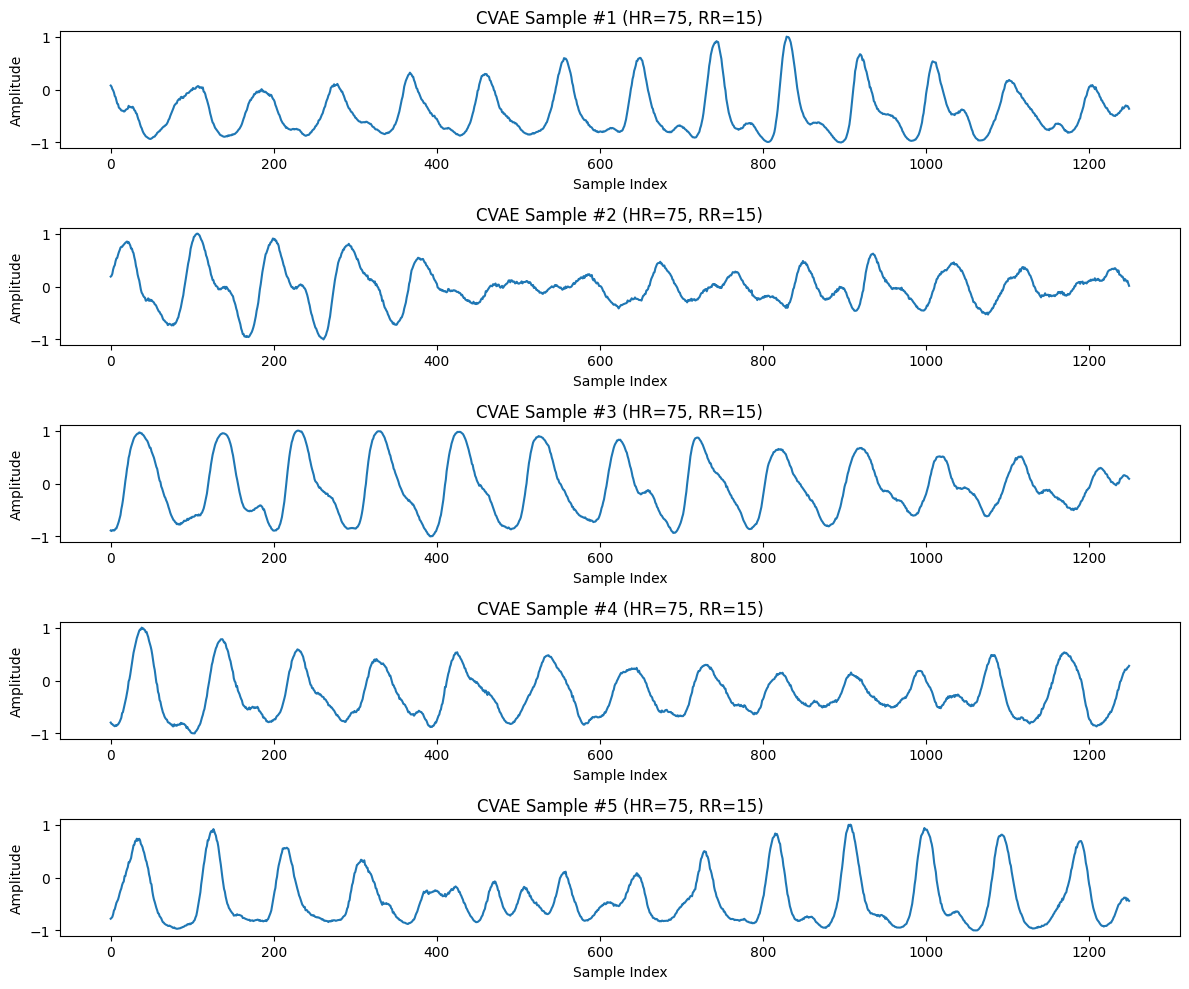

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


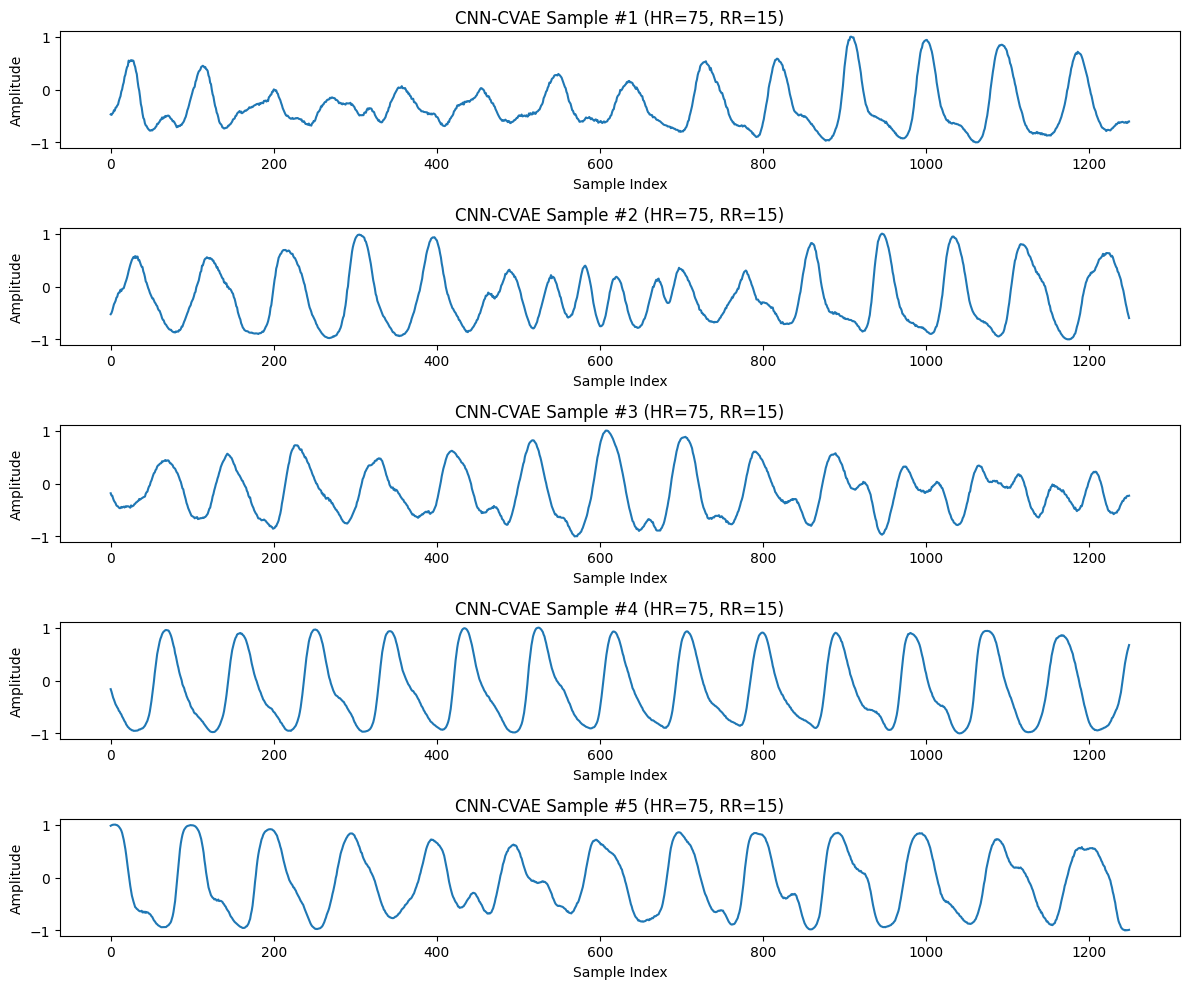

In [140]:
# Kiểm tra CVAE
plot_consistency_check(hr=75, rr=15, model_type='CVAE', num_samples=5)

# Kiểm tra CNN-CVAE
plot_consistency_check(hr=75, rr=15, model_type='CNN-CVAE', num_samples=5)

In [141]:
plt.figure(figsize=(12, 10))
for i in range(5):
    ppg = generate_ppg(75, 15, num_samples=1)
    ppg_signal = ppg[0]

    plt.subplot(5, 1, i+1)
    plt.plot(ppg_signal)
    plt.title(f'CVAE Sample #{i+1} (HR=75, RR=15)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.savefig(os.path.join(model_path, 'cvae_consistency_check.png'))
plt.close()
print("CVAE consistency check saved to 'models/cvae_consistency_check.png'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
CVAE consistency check saved to 'models/cvae_consistency_check.png'


In [142]:
plt.figure(figsize=(12, 10))
for i in range(5):
    ppg = generate_cnn_ppg(75, 15, num_samples=1)
    ppg_signal = ppg[0] if isinstance(ppg, np.ndarray) and ppg.ndim > 1 else ppg
    ppg_signal = ppg[0]

    plt.subplot(5, 1, i+1)
    plt.plot(ppg_signal)
    plt.title(f'CVAE Sample #{i+1} (HR=75, RR=15)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.savefig(os.path.join(model_path, 'cnn_cvae_consistency_check.png'))
plt.close()
print("CVAE consistency check saved to 'models/cnn_cvae_consistency_check.png'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
CVAE consistency check saved to 'models/cnn_cvae_consistency_check.png'


## 7. TIÊU CHÍ ĐÁNH GIÁ

### 7.1. Mô hình CVAE gốc (70%)
- Cài đặt đúng cấu trúc encoder và decoder (20%)
- Định nghĩa và áp dụng hàm mất mát phù hợp (15%)
- Tiền xử lý dữ liệu đúng và chuẩn hóa về khoảng [-1, 1] cho PPG và z-score cho HR, BR (15%)
- Huấn luyện mô hình đến khi hội tụ (10%)
- Tạo được tín hiệu PPG mới từ các thông số HR, BR cho trước (10%)

### 7.2. Mô hình CNN-CVAE (30%)
- Cài đặt đúng cấu trúc CNN encoder và decoder (15%)
- Huấn luyện mô hình đến khi hội tụ (10%)
- So sánh hiệu suất giữa hai mô hình (5%)

## 8. YÊU CẦU NỘP BÀI

1. **File notebook** (Jupyter/Colab) chứa toàn bộ mã nguồn có chú thích:
   - Code phải được tổ chức theo các section rõ ràng
   - Mỗi phần xử lý phải hiển thị kết quả để kiểm tra trước khi lưu
   - Sử dụng cell riêng biệt để kiểm tra kết quả và lưu file/hình ảnh

2. **Báo cáo** ngắn (1-2 trang) mô tả:
   - Phương pháp tiền xử lý dữ liệu
   - Kiến trúc mô hình CVAE và CNN-CVAE
   - Kết quả đánh giá và so sánh giữa hai mô hình
   - Ưu nhược điểm của từng phương pháp

3. **File mô hình đã huấn luyện** (.h5) cho CVAE gốc và CNN-CVAE

## 9. THỜI HẠN NỘP

Hai tuần kể từ ngày giao bài

## 10. TÀI NGUYÊN THAM KHẢO

- TensorFlow VAE Tutorial: https://www.tensorflow.org/tutorials/generative/cvae
- Keras CNN Documentation: https://keras.io/api/layers/convolution_layers/
- Bài giảng về Variational Autoencoders
- BIDMC PPG Dataset: https://physionet.org/content/bidmc/1.0.0/